# Crypto Funding Rate Arbitrage Strategy

## Introduction
This notebook explains the financial concepts discussed in the provided transcript (the specific words of internet crypto finance content creator **Benn Eifert**) regarding **Crypto Perpetual Futures** and **Funding Rate Arbitrage** (often called the "Cash and Carry" trade).

### The Core Claim
From Benn Eifert's discussion:
> *"If you understand how to do these things... [you can] get 50% 100% return per year annualized on a market neutral delta neutral basis."*

How is it possible to get high returns without caring if the price of Bitcoin goes up or down? Let's explore how this strategy works.

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import time

# Dark mode styling inspired by UNC baseball dark jerseys
plt.style.use('dark_background')
plt.rcParams.update({
    'figure.facecolor': '#1B3A6B',
    'axes.facecolor': '#0F1F3A',
    'axes.edgecolor': '#4B9CD3',
    'axes.labelcolor': '#E8E8E8',
    'xtick.color': '#E8E8E8',
    'ytick.color': '#E8E8E8',
    'text.color': '#E8E8E8',
    'grid.color': '#2A4A6B',
    'grid.alpha': 0.3,
    'figure.figsize': (14, 7),
    'legend.facecolor': '#1B3A6B',
    'legend.edgecolor': '#4B9CD3',
    'legend.framealpha': 0.9,
})
np.random.seed(42) # Ensure reproducibility

# Annotation Style Constants
# Rule: Use black facecolor for annotations on dark backgrounds (better visibility)
ANNOTATION_BBOX = dict(boxstyle='round', facecolor='black', alpha=0.8, edgecolor='#4B9CD3', linewidth=1)
ANNOTATION_TEXT_COLOR = '#E8E8E8'  # Light text for dark backgrounds

## Part 1: Understanding Perpetual Futures

### 1.1 The Problem with Regular Futures
In traditional finance (like the CME Bitcoin mention in Benn Eifert's discussion), futures contracts have an **expiry date**. As time approaches expiration, the Futures Price ($F$) must converge to the Spot Price ($S$).

### 1.2 The Innovation: Perpetual Futures
Crypto invented **Perpetual Futures**. These never expire. To keep the Futures price ($F$) tethered to the Spot price ($S$), exchanges use a mechanism called the **Funding Rate**.

Think of the Funding Rate as a mechanism that corrects price imbalances:

* If $F > S$ (Futures are expensive), demand is too high. The Funding Rate becomes **positive**. Longs must pay Shorts.
* If $F < S$ (Futures are cheap), demand is too low. The Funding Rate becomes **negative**. Shorts must pay Longs.

### 1.3 Calculating Accumulated Funding

The accumulated funding you receive (or pay) over time can be expressed as:

$$ C(t) = \int_{0}^{t} P_{position} \cdot r(\tau) \, d\tau $$

Where:
* $P_{position}$ is the size of your position (in USD)
* $r(\tau)$ is the funding rate at time $\tau$ (typically paid every 8 hours)
* $C(t)$ is the total funding accumulated from time 0 to time $t$

**In plain terms:** This formula sums up all the funding payments you receive over time. Since funding is typically paid every 8 hours, in practice you can think of it as:

$$ C(t) \approx \sum_{i=1}^{n} P_{position} \times r_i $$

Where $n$ is the number of funding periods (3 per day), and $r_i$ is the funding rate for period $i$. This is simply: **Funding Income = Position Size × Funding Rate × Number of Periods**

## Part 2: Understanding "Delta Neutrality"

Benn Eifert mentions a **"Market Neutral Delta Neutral Basis."** This means your portfolio doesn't care if the price goes up or down.

The strategy uses two positions:
1.  **Long Spot** (Buying the actual coin) - represented as $\vec{S}$
2.  **Short Perpetual Future** (Selling futures contracts) - represented as $\vec{F_{short}}$

### 2.1 How Delta Neutrality Works

If Bitcoin price moves by $\Delta x$:
* Your Long Spot position changes by $+\Delta x$
* Your Short Futures position changes by $-\Delta x$

**The key insight:** These two positions cancel each other out. Mathematically, we can express the net portfolio change as:

$$ \Delta \vec{P} = \vec{S} + \vec{F_{short}} = (+\Delta x) + (-\Delta x) = 0 $$

This means the net change from price movements is approximately zero - you're **delta neutral**.

### 2.2 Why Funding Still Works

However, while the *price action* cancels out, the **Funding Rate** does not. Since you are Short and the market is usually Long (Positive Funding), you **collect** the funding payments.

Your total return becomes:
$$ \text{Return} = \underbrace{(\text{Spot PnL} - \text{Futures PnL})}_{\approx 0 \text{ (Delta Neutral)}} + \underbrace{\text{Funding Income}}_{\text{Positive Yield}} $$

**In plain terms:** The price movements cancel out (delta neutral), but you still collect funding payments because you're on the receiving end of the funding rate.

## Part 3: Simulation with Realistic Market Data

Since we cannot pull live data in this notebook, we will generate a dataset that mathematically mimics the statistical properties of a volatile crypto asset (like Solana or Avalanche during a bull run).

**Model Parameters:**
* **Geometric Brownian Motion:** Used to simulate the "Random Walk" of crypto prices.
* **Volatility ($ \sigma $):** High (80% annualized).
* **Funding Rate Logic:** In crypto, funding rates are correlated with price momentum. If price moons, funding spikes.

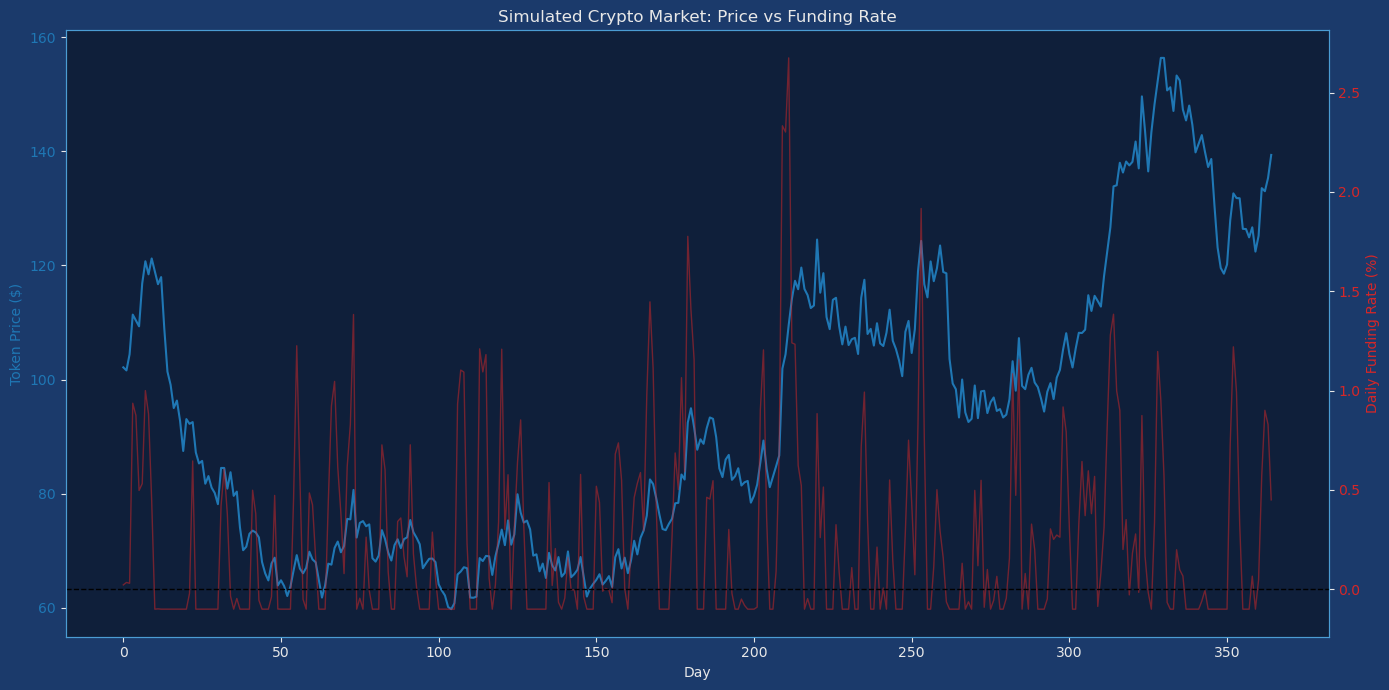

In [2]:
def generate_crypto_market_data(days=365, initial_price=100, volatility=0.8):
    """
    Generates synthetic price and funding rate data.
    Uses Geometric Brownian Motion for price.
    Models Funding Rate as correlated to price momentum (common in crypto).
    """
    dt = 1/365
    mu = 0.5 # Annualized drift (Bull market scenario)
    
    # 1. Generate Price Path (Geometric Brownian Motion)
    # dS/S = mu*dt + sigma*dW
    rets = np.random.normal(loc=(mu - 0.5 * volatility**2) * dt, 
                            scale=volatility * np.sqrt(dt), 
                            size=days)
    price_path = initial_price * np.exp(np.cumsum(rets))
    
    # 2. Generate Funding Rates
    # Funding rates in crypto are mean-reverting but spike when momentum is high.
    # Base rate is usually 0.01% per 8 hours (0.03% daily)
    base_daily_funding = 0.0003 
    
    # Create a momentum factor (price change over last 3 days)
    momentum = pd.Series(price_path).pct_change(3).fillna(0)
    
    # Funding rate = Base + (Sensitivity * Momentum) + Noise
    # When price rips up, funding spikes (Longs pay shorts)
    funding_rates = base_daily_funding + (0.1 * momentum) + np.random.normal(0, 0.0002, days)
    
    # Ensure funding mostly stays positive (typical for bull market) but can dip negative
    funding_rates = np.maximum(funding_rates, -0.001)
    
    return pd.DataFrame({
        'Day': range(days),
        'Spot_Price': price_path,
        'Daily_Funding_Rate': funding_rates
    })

# Generate the dataset
df = generate_crypto_market_data()

# Visualize the Market Environment
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Day')
ax1.set_ylabel('Token Price ($)', color=color)
ax1.plot(df['Day'], df['Spot_Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Simulated Crypto Market: Price vs Funding Rate")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Daily Funding Rate (%)', color=color)
ax2.plot(df['Day'], df['Daily_Funding_Rate'] * 100, color=color, alpha=0.5, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)

fig.tight_layout()
plt.show()

### Analysis of the Graph
Notice the relationship between the **Blue Line** (Price) and the **Red Line** (Funding Rate):
1.  When the Price moves up sharply (steep slope), the Funding Rate spikes. This represents the "excess demand" mentioned by Benn Eifert.
2.  This Red line is the **Yield** you collect by being Short.

## Part 4: Executing the Strategy (The Backtest)

Now we simulate the "Cash and Carry" strategy.

**The Strategy Algorithm:**
1.  **Start:** with $10,000.
2.  **Buy Spot:** Spend $10,000 on the token.
3.  **Short Perp:** Short $10,000 worth of the token (1x leverage).
4.  **Daily Loop:**
    * Calculate Spot PnL: $(\text{Price}_{today} - \text{Price}_{yesterday}) \times \text{Holdings}$
    * Calculate Short PnL: $-(\text{Price}_{today} - \text{Price}_{yesterday}) \times \text{Holdings}$
    * **Collect Funding:** $\text{Position Value} \times \text{Funding Rate}$

Ideally, Spot PnL and Short PnL cancel out perfectly (Zero Delta).

In [3]:
initial_capital = 10000

# Track our portfolio over time
cash = np.zeros(len(df))
portfolio_value = np.zeros(len(df))
cumulative_funding = np.zeros(len(df))

# Initialize
# We split capital? No, in this simplified version:
# We use $10k to buy Spot. We use that Spot as collateral to Short $10k Futures.
# This is "1x Short" against Spot Collateral.

quantity_tokens = initial_capital / df['Spot_Price'][0]

for t in range(1, len(df)):
    # 1. Calculate Prices
    price_prev = df['Spot_Price'][t-1]
    price_curr = df['Spot_Price'][t]
    funding_rate = df['Daily_Funding_Rate'][t]
    
    # 2. Asset Performances
    # Spot Gain/Loss
    spot_pnl = (price_curr - price_prev) * quantity_tokens
    
    # Short Perp Gain/Loss (Inverse of spot)
    short_pnl = -(price_curr - price_prev) * quantity_tokens
    
    # 3. Funding Income
    # We are Short, so if Rate is Positive, we RECEIVE money.
    # Income = Position_Size_USD * Funding_Rate
    position_size_usd = quantity_tokens * price_curr
    funding_income = position_size_usd * funding_rate
    
    # 4. Aggregate
    # Note: Spot_PnL and Short_PnL cancel to 0 (theoretically)
    daily_total_pnl = spot_pnl + short_pnl + funding_income
    
    # Update accumulators
    if t == 1:
        cumulative_funding[t] = funding_income
        portfolio_value[t] = initial_capital + daily_total_pnl
    else:
        cumulative_funding[t] = cumulative_funding[t-1] + funding_income
        portfolio_value[t] = portfolio_value[t-1] + daily_total_pnl

portfolio_value[0] = initial_capital

# Add to dataframe
df['Strategy_Equity'] = portfolio_value
df['Buy_Hold_Equity'] = (df['Spot_Price'] / df['Spot_Price'][0]) * initial_capital
df['Cumulative_Funding_USD'] = cumulative_funding

# Calculate Returns
strategy_return = (df['Strategy_Equity'].iloc[-1] - initial_capital) / initial_capital
buy_hold_return = (df['Buy_Hold_Equity'].iloc[-1] - initial_capital) / initial_capital

print(f"Scenario Results over {len(df)} days:")
print(f"Strategy Annualized Return: {strategy_return:.2%}")
print(f"Buy & Hold Return: {buy_hold_return:.2%}")

Scenario Results over 365 days:
Strategy Annualized Return: 89.39%
Buy & Hold Return: 36.44%


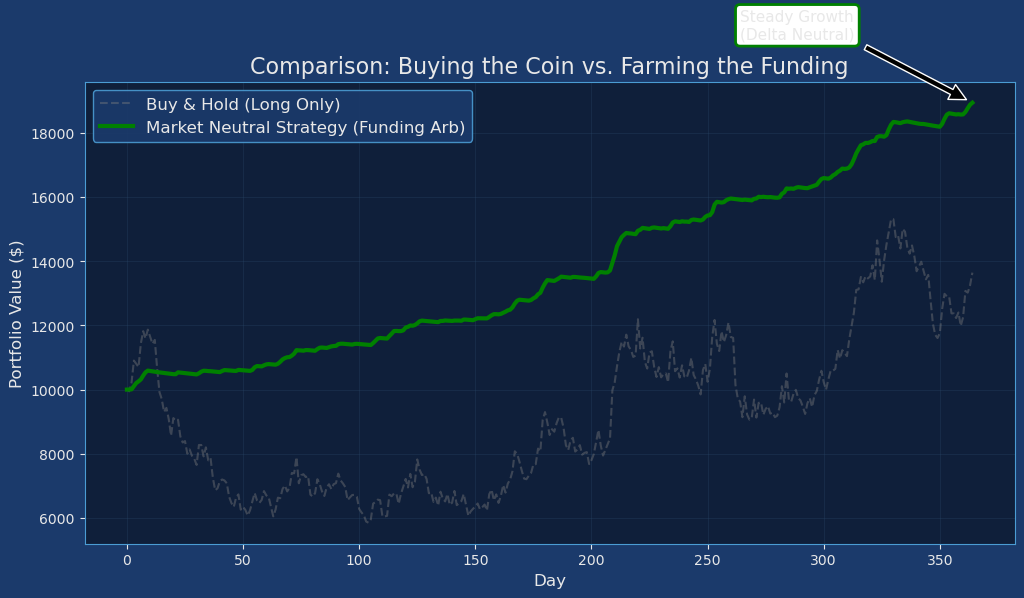

In [4]:
# Visualization: The "Tortoise and the Hare"
plt.figure(figsize=(12, 6))

# Plot Buy and Hold (The Hare)
plt.plot(df['Day'], df['Buy_Hold_Equity'], label='Buy & Hold (Long Only)', color='grey', alpha=0.4, linestyle='--')

# Plot Funding Strategy (The Tortoise)
plt.plot(df['Day'], df['Strategy_Equity'], label='Market Neutral Strategy (Funding Arb)', color='green', linewidth=3)

plt.title('Comparison: Buying the Coin vs. Farming the Funding', fontsize=16)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)

# Add text annotation for the result
plt.annotate(f'Steady Growth\n(Delta Neutral)', 
             xy=(df['Day'].iloc[-1], df['Strategy_Equity'].iloc[-1]), 
             xytext=(df['Day'].iloc[-1]-100, df['Strategy_Equity'].iloc[-1]+2000),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=11, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", lw=2))

plt.show()

### Interpretation

Look at the Green Line. It moves up almost linearly. Why?

Since we removed the price volatility (Delta Neutral), our chart represents the **accumulation of funding payments over time**. 

Recall from Part 1, the accumulated funding is:
$$ C(t) = \int_{0}^{t} P_{position} \cdot r(\tau) \, d\tau $$

Since the funding rate $r(\tau)$ is mostly positive (and relatively stable), this integral produces a steady upward trend. **In plain terms:** We're continuously adding up positive funding payments, which creates a smooth upward line.

This visualizes Benn Eifert's claim:
> *"get 50% 100% return per year annualized on a market neutral delta neutral basis."*

Even though the grey line (Buy & Hold) went much higher at one point, it crashed. The Strategy line kept chugging along, steadily collecting funding regardless of price direction.

## Part 5: Why does this exist? (CME vs. Crypto)

Benn Eifert asks: *"Why are those spreads so large?"* compared to CME Bitcoin futures.

We can explain this using a **Risk Premium** equation.

$$ \text{Expected Return} = R_{risk\_free} + \beta(\text{Market Risk}) + \alpha(\text{Idiosyncratic Risk}) $$

1.  **CME Bitcoin:**
    * Regulated exchange.
    * No "Hack" risk.
    * Institutional access.
    * **Result:** Low Risk $\to$ Low Return (Efficient Market).

2.  **Crypto Perpetuals:**
    * **Operational Risk:** You have to move money between wallets.
    * **Exchange Risk:** The exchange (e.g., FTX, Mt Gox) might disappear.
    * **Liquidation Risk:** If price spikes 50% in a minute, your short might get liquidated before you can rebalance.
    * **Result:** High Risk Premium. You are paid for risks "other people don't know how to take."

### Visualizing the Risk
The strategy isn't actually a perfectly straight line. It has "Drawdown Risk" if funding rates flip negative.

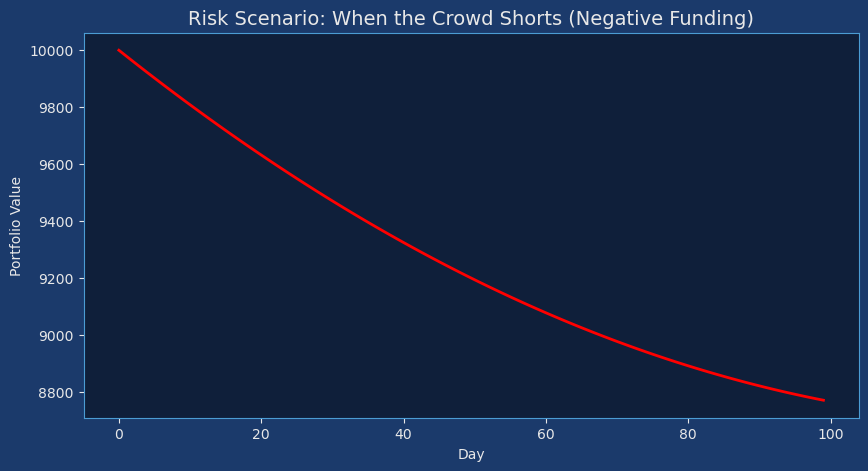

In [5]:
# Let's simulate what happens in a "Bear Market" scenario where everyone shorts
# Funding becomes negative (Shorts pay Longs)

def bear_market_simulation():
    days = 100
    # Price crashes
    prices = 100 * np.exp(np.linspace(0, -0.5, days))
    # Funding rate turns negative because everyone is shorting
    funding = np.linspace(-0.002, -0.0005, days)
    
    equity = [10000]
    accumulated_funding = 0
    
    for i in range(1, days):
        # Delta neutral means no price PnL, only Funding PnL
        # But funding is negative!
        position_size = 10000
        daily_cost = position_size * funding[i]
        equity.append(equity[-1] + daily_cost)
        
    return equity

bear_equity = bear_market_simulation()

plt.figure(figsize=(10, 5))
plt.plot(bear_equity, color='red', linewidth=2)
plt.title('Risk Scenario: When the Crowd Shorts (Negative Funding)', fontsize=14)
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.show()

## Conclusion

The strategy described by Benn Eifert works because the **Long Spot** and **Short Futures** positions cancel out price movements (Delta Neutral), while you continue to collect funding payments.

However, the high yield (50-100%) is a market compensation for **complexity and operational risk**, not a magic money printer. If the market sentiment shifts (as seen in the red chart above), funding rates can turn negative and the strategy can lose money.

**Summary Checklist for the Strategy:**
1.  **Long** the Spot Asset.
2.  **Short** the Perpetual Future.
3.  Ensure **Liquidity** (don't pick a coin that you can't sell).
4.  Monitor **Funding Rates** (ensure they stay positive).
5.  Rebalance margins to prevent **Liquidation**.

---
## Part 6: Historical Analysis with Real Bitcoin Data

Now let's analyze the strategy using historical Bitcoin perpetual futures data from 2020 to 2024. This will show us how the strategy performs in real market conditions, including both bull and bear markets.


In [6]:
# Load historical Bitcoin data
# Expected CSV format: timestamp, fundingRate, closePrice

import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import numpy as np

def fetch_kraken_funding(start_date='2020-01-01', end_date='2024-12-31', save_to_csv=True):
    """
    Fetch Bitcoin funding rate and price data from Kraken Futures API.
    US-accessible, no API key required.
    
    Parameters:
    - start_date: Start date in 'YYYY-MM-DD' format
    - end_date: End date in 'YYYY-MM-DD' format
    - save_to_csv: If True, saves data to 'btc_funding_data.csv'
    
    Returns:
    - DataFrame with columns: timestamp, fundingRate, closePrice
    """
    print("Fetching real Bitcoin data from Kraken Futures API...")
    print("This may take a few minutes for 5 years of data...")
    
    start_dt = pd.Timestamp(start_date)
    end_dt = pd.Timestamp(end_date)
    
    all_funding_data = []
    all_price_data = []
    
    # Fetch funding rate data - loop backward from end_date
    print("Fetching funding rate data from Kraken...")
    current_time = end_dt
    
    while current_time >= start_dt:
        params = {
            'symbol': 'PI_XBTUSD',
            'count': 1000
        }
        
        try:
            response = requests.get('https://futures.kraken.com/derivatives/api/v3/historical-funding-rates', params=params, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if not data.get('result') or not data['result'].get('rates'):
                break
            
            rates = data['result']['rates']
            all_funding_data.extend(rates)
            
            if rates:
                oldest_timestamp = pd.to_datetime(rates[-1]['time'], unit='ms')
                if oldest_timestamp < current_time:
                    current_time = oldest_timestamp
                else:
                    break
            else:
                break
            
            time.sleep(0.2)
            
            if len(all_funding_data) % 1000 == 0:
                print(f"  Fetched {len(all_funding_data)} funding rate records...")
                
        except Exception as e:
            print(f"Error fetching funding data: {e}")
            break
    
    # Fetch price data
    print("Fetching price data from Kraken...")
    current_time = start_dt
    
    while current_time <= end_dt:
        params = {
            'symbol': 'PI_XBTUSD',
            'interval': '1h',
            'from': int(current_time.timestamp()),
            'to': int(min(current_time + timedelta(days=30), end_dt).timestamp())
        }
        
        try:
            response = requests.get('https://futures.kraken.com/derivatives/api/v3/tickers/historical', params=params, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if not data.get('result') or not data['result'].get('tickers'):
                break
            
            tickers = data['result']['tickers']
            all_price_data.extend(tickers)
            
            if tickers:
                latest_timestamp = pd.to_datetime(tickers[-1]['time'], unit='ms')
                current_time = latest_timestamp + timedelta(hours=1)
            else:
                break
            
            time.sleep(0.2)
            
            if len(all_price_data) % 1000 == 0:
                print(f"  Fetched {len(all_price_data)} price records...")
                
        except Exception as e:
            print(f"Error fetching price data: {e}")
            break
    
    # Process funding rate data
    if len(all_funding_data) == 0:
        raise ValueError("No funding rate data retrieved from Kraken.")
    
    funding_records = []
    for record in all_funding_data:
        funding_records.append({
            'timestamp': pd.to_datetime(record['time'], unit='ms'),
            'fundingRate': float(record['fundingRate'])
        })
    
    funding_df = pd.DataFrame(funding_records)
    funding_df.set_index('timestamp', inplace=True)
    funding_df.sort_index(inplace=True)
    funding_df = funding_df[~funding_df.index.duplicated(keep='last')]
    
    # Process price data
    price_records = []
    for ticker in all_price_data:
        price_records.append({
            'timestamp': pd.to_datetime(ticker['time'], unit='ms'),
            'closePrice': float(ticker.get('last', ticker.get('close', 0)))
        })
    
    price_df = pd.DataFrame(price_records)
    price_df.set_index('timestamp', inplace=True)
    price_df.sort_index(inplace=True)
    price_df = price_df[~price_df.index.duplicated(keep='last')]
    
    # Resample to 8-hour intervals
    funding_df = funding_df.resample('8h').last()
    price_df = price_df.resample('8h').last()
    
    # Merge funding rate and price data
    df = funding_df.join(price_df, how='outer')
    df['closePrice'] = df['closePrice'].ffill()
    df['fundingRate'] = df['fundingRate'].ffill()
    
    # Filter to date range and sort
    df = df[(df.index >= start_date) & (df.index <= end_date)]
    df = df.sort_index()
    df = df.dropna(subset=['fundingRate', 'closePrice'], how='all')
    
    print(f"\nSuccessfully fetched {len(df)} data points from {df.index[0].date()} to {df.index[-1].date()}")
    print(f"Funding rate records: {df['fundingRate'].notna().sum()}")
    print(f"Price records: {df['closePrice'].notna().sum()}")
    
    if save_to_csv:
        output_df = df.reset_index()
        output_df.to_csv('btc_funding_data.csv', index=False)
        print(f"Data saved to 'btc_funding_data.csv'")
    
    return df

def fetch_bybit_funding_robust(start_date='2020-01-01', end_date='2024-12-31', save_to_csv=True):
    """
    Fetch real Bitcoin funding rate and price data from Bybit API with proper headers.
    Fixed 403 error by adding User-Agent header.
    
    Parameters:
    - start_date: Start date in 'YYYY-MM-DD' format
    - end_date: End date in 'YYYY-MM-DD' format
    - save_to_csv: If True, saves data to 'btc_funding_data.csv'
    
    Returns:
    - DataFrame with columns: timestamp, fundingRate, closePrice
    """
    print("Fetching real Bitcoin data from Bybit API...")
    print("This may take a few minutes for 5 years of data...")
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36'
    }
    
    start_ts = int(pd.Timestamp(start_date).timestamp())
    end_ts = int(pd.Timestamp(end_date).timestamp())
    
    all_funding_data = []
    all_price_data = []
    
    # Fetch funding rate data (paid every 8 hours) - loop backward from end_date
    print("Fetching funding rate data from Bybit...")
    current_ts = end_ts
    limit = 200
    
    while current_ts >= start_ts:
        params = {
            'category': 'linear',
            'symbol': 'BTCUSDT',
            'endTime': current_ts * 1000,
            'limit': str(limit)
        }
        
        try:
            response = requests.get('https://api.bybit.com/v5/market/funding/history', params=params, headers=headers, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if data.get('retCode') != 0 or not data.get('result', {}).get('list'):
                break
            
            funding_list = data['result']['list']
            all_funding_data.extend(funding_list)
            
            if funding_list:
                current_ts = int(funding_list[-1]['fundingRateTimestamp']) // 1000 - 1
            else:
                break
            
            time.sleep(0.2)
            
            if len(all_funding_data) % 1000 == 0:
                print(f"  Fetched {len(all_funding_data)} funding rate records...")
                
        except Exception as e:
            print(f"Error fetching funding data: {e}")
            break
    
    # Fetch price data (hourly candles, then resample to 8-hour)
    print("Fetching price data from Bybit...")
    current_ts = start_ts
    
    while current_ts < end_ts:
        params = {
            'category': 'linear',
            'symbol': 'BTCUSDT',
            'interval': '60',
            'start': current_ts * 1000,
            'end': min((current_ts + (1000 * 3600)) * 1000, end_ts * 1000),
            'limit': '1000'
        }
        
        try:
            response = requests.get('https://api.bybit.com/v5/market/kline', params=params, headers=headers, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if data.get('retCode') != 0 or not data.get('result', {}).get('list'):
                break
            
            klines = data['result']['list']
            all_price_data.extend(klines)
            
            if klines:
                current_ts = int(klines[-1][0]) // 1000 + 3600
            else:
                break
            
            time.sleep(0.2)
            
            if len(all_price_data) % 1000 == 0:
                print(f"  Fetched {len(all_price_data)} price records...")
                
        except Exception as e:
            print(f"Error fetching price data: {e}")
            break
    
    # Process funding rate data
    if len(all_funding_data) == 0:
        raise ValueError("No funding rate data retrieved from Bybit. Check API connection.")
    
    funding_records = []
    for record in all_funding_data:
        funding_records.append({
            'timestamp': pd.to_datetime(int(record['fundingRateTimestamp']), unit='ms'),
            'fundingRate': float(record['fundingRate'])
        })
    
    funding_df = pd.DataFrame(funding_records)
    funding_df.set_index('timestamp', inplace=True)
    funding_df.sort_index(inplace=True)
    funding_df = funding_df[~funding_df.index.duplicated(keep='last')]
    
    # Process price data
    price_records = []
    for kline in all_price_data:
        price_records.append({
            'timestamp': pd.to_datetime(int(kline[0]), unit='ms'),
            'closePrice': float(kline[4])
        })
    
    price_df = pd.DataFrame(price_records)
    price_df.set_index('timestamp', inplace=True)
    price_df.sort_index(inplace=True)
    price_df = price_df[~price_df.index.duplicated(keep='last')]
    
    # Resample to 8-hour intervals
    funding_df = funding_df.resample('8h').last()
    price_df = price_df.resample('8h').last()
    
    # Merge funding rate and price data
    df = funding_df.join(price_df, how='outer')
    df['closePrice'] = df['closePrice'].ffill()
    df['fundingRate'] = df['fundingRate'].ffill()
    
    # Filter to date range and sort
    df = df[(df.index >= start_date) & (df.index <= end_date)]
    df = df.sort_index()
    df = df.dropna(subset=['fundingRate', 'closePrice'], how='all')
    
    print(f"\nSuccessfully fetched {len(df)} data points from {df.index[0].date()} to {df.index[-1].date()}")
    print(f"Funding rate records: {df['fundingRate'].notna().sum()}")
    print(f"Price records: {df['closePrice'].notna().sum()}")
    
    if save_to_csv:
        output_df = df.reset_index()
        output_df.to_csv('btc_funding_data.csv', index=False)
        print(f"Data saved to 'btc_funding_data.csv'")
    
    return df

def get_robust_btc_data(start_date='2020-01-01', end_date='2024-12-31', save_to_csv=True):
    """
    Master function to fetch Bitcoin data with fallback logic.
    Attempts: Bybit (robust) -> Kraken -> Synthetic data
    
    Parameters:
    - start_date: Start date in 'YYYY-MM-DD' format
    - end_date: End date in 'YYYY-MM-DD' format
    - save_to_csv: If True, saves data to 'btc_funding_data.csv'
    
    Returns:
    - DataFrame with columns: timestamp, fundingRate, closePrice
    """
    # Attempt 1: Bybit (robust with headers)
    try:
        return fetch_bybit_funding_robust(start_date, end_date, save_to_csv)
    except Exception as e:
        print(f"Bybit failed: {e}")
        print("Bybit failed, switching to Kraken...")
    
    # Attempt 2: Kraken
    try:
        return fetch_kraken_funding(start_date, end_date, save_to_csv)
    except Exception as e:
        print(f"Kraken failed: {e}")
        print("Warning: Using Synthetic Data")
    
    # Attempt 3: Synthetic data
    return generate_synthetic_btc_data()

def fetch_btc_data_from_binance(start_date='2020-01-01', end_date='2024-12-31', save_to_csv=True):
    """
    Fetch real Bitcoin funding rate and price data.
    Uses robust fallback logic: Bybit -> Kraken -> Synthetic
    
    Parameters:
    - start_date: Start date in 'YYYY-MM-DD' format
    - end_date: End date in 'YYYY-MM-DD' format  
    - save_to_csv: If True, saves data to 'btc_funding_data.csv'
    
    Returns:
    - DataFrame with columns: timestamp, fundingRate, closePrice
    """
    return get_robust_btc_data(start_date, end_date, save_to_csv)

def load_btc_data(filepath='btc_funding_data.csv', fetch_if_missing=True):
    """
    Load Bitcoin perpetual futures data from CSV.
    
    If CSV file is not found and fetch_if_missing=True, attempts to fetch
    real data using robust fallback logic. Falls back to synthetic data if API fetch fails.
    
    Parameters:
    - filepath: Path to CSV file (default: 'btc_funding_data.csv')
    - fetch_if_missing: If True, fetch from API when CSV is missing
    
    Expected CSV columns:
    - timestamp: Date/time (will be parsed)
    - fundingRate: Funding rate (typically per 8-hour period, as decimal)
    - closePrice: Spot price of Bitcoin
    
    Returns: DataFrame with datetime index
    """
    try:
        df = pd.read_csv(filepath)
        
        # Parse timestamp
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        # Ensure numeric columns
        df['fundingRate'] = pd.to_numeric(df['fundingRate'], errors='coerce')
        df['closePrice'] = pd.to_numeric(df['closePrice'], errors='coerce')
        
        # Sort by date
        df.sort_index(inplace=True)
        
        # Filter to 2020-2024
        df = df[(df.index >= '2020-01-01') & (df.index <= '2024-12-31')]
        
        print(f"Loaded {len(df)} data points from {df.index[0].date()} to {df.index[-1].date()}")
        return df
        
    except FileNotFoundError:
        if fetch_if_missing:
            print(f"File '{filepath}' not found.")
            print("Attempting to fetch real data from API...")
            try:
                return get_robust_btc_data()
            except Exception as e:
                print(f"Failed to fetch data: {e}")
                print("Falling back to synthetic data generation...")
                return generate_synthetic_btc_data()
        else:
            print(f"File '{filepath}' not found. Generating synthetic Bitcoin data for demonstration...")
            return generate_synthetic_btc_data()


def generate_synthetic_btc_data():
    """
    Generate realistic synthetic Bitcoin data for 2020-2024 if CSV is not available.
    This mimics real market conditions including bull and bear periods.
    Ensures all funding rates are valid (non-NaN) for downstream analysis.
    """
    # Create date range
    dates = pd.date_range(start='2020-01-01', end='2024-12-31', freq='8h')
    
    # Simulate Bitcoin price with realistic bull/bear cycles
    np.random.seed(42)
    n = len(dates)
    
    # Price simulation with major bull run 2020-2021, crash 2022, recovery 2023-2024
    initial_price = 7000  # BTC price in Jan 2020
    
    # Create trend components for different periods
    trend_2020_2021 = np.linspace(0, 3.0, sum((dates >= '2020-01-01') & (dates < '2022-01-01')))  # Bull run
    trend_2022 = np.linspace(0, -1.5, sum((dates >= '2022-01-01') & (dates < '2023-01-01')))  # Bear market
    trend_2023_2024 = np.linspace(0, 1.0, sum((dates >= '2023-01-01') & (dates <= '2024-12-31')))  # Recovery
    
    trend = np.concatenate([trend_2020_2021, trend_2022, trend_2023_2024])
    
    # Add volatility
    volatility = 0.6
    dt = 1/(365*3)  # 8-hour periods
    random_walk = np.random.normal(0, volatility * np.sqrt(dt), n)
    
    # Combine trend and random walk
    log_returns = (trend / len(trend)) + random_walk
    prices = initial_price * np.exp(np.cumsum(log_returns))
    
    # Generate funding rates correlated with price momentum
    # In bull markets: high positive funding (everyone wants to long)
    # In bear markets: negative funding (everyone wants to short)
    
    # Calculate price momentum (10-period percentage change)
    price_series = pd.Series(prices, index=dates)
    price_returns = price_series.pct_change(10).fillna(0)  # 10-period momentum, fill NaN with 0
    
    # Base funding rate (0.01% per 8 hours, typical for crypto)
    base_funding = 0.0001
    
    # Funding spikes with positive momentum, goes negative with negative momentum
    # Convert price_returns to numpy array to ensure proper alignment
    price_returns_array = price_returns.values
    funding_rates = base_funding + (0.5 * price_returns_array) + np.random.normal(0, 0.0001, n)
    
    # Ensure realistic bounds (-0.2% to +0.2% per 8h)
    funding_rates = np.clip(funding_rates, -0.002, 0.002)
    
    # Ensure no NaN or inf values
    funding_rates = np.nan_to_num(funding_rates, nan=base_funding, posinf=0.002, neginf=-0.002)
    
    # Create DataFrame with proper alignment
    df = pd.DataFrame({
        'fundingRate': funding_rates,
        'closePrice': prices
    }, index=dates)
    
    # Final validation: ensure no NaN values
    assert df['fundingRate'].notna().all(), "Funding rates contain NaN values!"
    assert df['closePrice'].notna().all(), "Prices contain NaN values!"
    
    # Verify data quality
    funding_count = df['fundingRate'].notna().sum()
    price_count = df['closePrice'].notna().sum()
    
    print(f"Generated {len(df)} synthetic data points from {df.index[0].date()} to {df.index[-1].date()}")
    print(f"Funding rate records: {funding_count} (all valid)")
    print(f"Price records: {price_count} (all valid)")
    print(f"Funding rate range: {df['fundingRate'].min():.6f} to {df['fundingRate'].max():.6f}")
    print("Note: Replace with real data by providing 'btc_funding_data.csv' with columns: timestamp, fundingRate, closePrice")
    
    return df


# Load or generate data
btc_data = load_btc_data()

# Display sample
print("\nFirst few rows:")
print(btc_data.head())
print("\nData statistics:")
print(btc_data.describe())


File 'btc_funding_data.csv' not found.
Attempting to fetch real data from API...
Fetching real Bitcoin data from Bybit API...
This may take a few minutes for 5 years of data...
Fetching funding rate data from Bybit...
Error fetching funding data: 403 Client Error: Forbidden for url: https://api.bybit.com/v5/market/funding/history?category=linear&symbol=BTCUSDT&endTime=1735603200000&limit=200
Fetching price data from Bybit...
Error fetching price data: 403 Client Error: Forbidden for url: https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1577836800000&end=1581436800000&limit=1000
Bybit failed: No funding rate data retrieved from Bybit. Check API connection.
Bybit failed, switching to Kraken...
Fetching real Bitcoin data from Kraken Futures API...
This may take a few minutes for 5 years of data...
Fetching funding rate data from Kraken...
Error fetching funding data: 'str' object has no attribute 'get'
Fetching price data from Kraken...
Error fetching

### 6.1 Calculating Cumulative Returns (2020-2024)

Now we'll implement the Cash and Carry strategy on the historical data and calculate cumulative returns.


In [7]:
def calculate_cash_and_carry_returns(df, initial_capital=10000):
    """
    Calculate cumulative returns of Cash and Carry strategy.
    
    Strategy:
    - Long Spot: Buy Bitcoin at initial price
    - Short Perpetual: Short equivalent amount of perpetual futures
    - Collect funding payments (positive when funding rate > 0, pay when < 0)
    
    Returns: DataFrame with strategy metrics
    """
    # Initialize
    initial_price = df['closePrice'].iloc[0]
    quantity_tokens = initial_capital / initial_price
    
    # Arrays to track portfolio
    portfolio_value = np.zeros(len(df))
    cumulative_funding = np.zeros(len(df))
    spot_value = np.zeros(len(df))
    funding_income = np.zeros(len(df))
    
    portfolio_value[0] = initial_capital
    spot_value[0] = initial_capital
    
    # Calculate daily PnL
    for i in range(1, len(df)):
        price_prev = df['closePrice'].iloc[i-1]
        price_curr = df['closePrice'].iloc[i]
        funding_rate = df['fundingRate'].iloc[i]
        
        # Spot PnL (price change on our long position)
        spot_pnl = (price_curr - price_prev) * quantity_tokens
        
        # Short Futures PnL (inverse of spot)
        short_pnl = -(price_curr - price_prev) * quantity_tokens
        
        # Funding income (we're short, so positive funding = income, negative = cost)
        position_value = quantity_tokens * price_curr
        funding_payment = position_value * funding_rate
        funding_income[i] = funding_payment
        
        # Total PnL (spot + short should cancel, leaving only funding)
        daily_pnl = spot_pnl + short_pnl + funding_payment
        
        # Update portfolio
        portfolio_value[i] = portfolio_value[i-1] + daily_pnl
        cumulative_funding[i] = cumulative_funding[i-1] + funding_payment
        spot_value[i] = quantity_tokens * price_curr
    
    # Add to dataframe
    result_df = df.copy()
    result_df['Strategy_Equity'] = portfolio_value
    result_df['Cumulative_Funding'] = cumulative_funding
    result_df['Funding_Income'] = funding_income
    result_df['Spot_Value'] = spot_value
    result_df['Strategy_Return'] = (portfolio_value - initial_capital) / initial_capital
    
    return result_df

# Calculate strategy returns
strategy_df = calculate_cash_and_carry_returns(btc_data)

# Calculate total return
total_return = (strategy_df['Strategy_Equity'].iloc[-1] - 10000) / 10000
years = (strategy_df.index[-1] - strategy_df.index[0]).days / 365.25
annualized_return = (1 + total_return) ** (1/years) - 1

print("=" * 70)
print("CASH AND CARRY STRATEGY RESULTS (2020-2024)")
print("=" * 70)
print(f"Initial Capital: ${10000:,.2f}")
print(f"Final Portfolio Value: ${strategy_df['Strategy_Equity'].iloc[-1]:,.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Period: {years:.2f} years")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Total Funding Collected: ${strategy_df['Cumulative_Funding'].iloc[-1]:,.2f}")
print("=" * 70)


CASH AND CARRY STRATEGY RESULTS (2020-2024)
Initial Capital: $10,000.00
Final Portfolio Value: $29,021.00
Total Return: 190.21%
Period: 5.00 years
Annualized Return: 23.75%
Total Funding Collected: $19,021.00


### 6.2 Annualized Rolling Yield

The **Annualized Rolling Yield** shows how profitable the strategy is over time. We'll calculate a 30-day moving average of the annualized funding rate to smooth out short-term volatility and identify bull vs bear market periods.


In [8]:
# Calculate annualized funding rate
# Funding rates are typically per 8-hour period (3 per day)
# Annualized = funding_rate * 3 * 365

strategy_df['Annualized_Funding_Rate'] = strategy_df['fundingRate'] * 3 * 365 * 100  # Convert to percentage

# Calculate 30-day rolling average (approximately 90 periods for 8-hour data)
# 30 days * 3 periods per day = 90 periods
window = 90
strategy_df['Rolling_Annualized_Yield'] = strategy_df['Annualized_Funding_Rate'].rolling(window=window, min_periods=1).mean()

# Also calculate cumulative funding as percentage of initial capital
strategy_df['Funding_Return_Pct'] = (strategy_df['Cumulative_Funding'] / 10000) * 100

print("Annualized Rolling Yield Statistics:")
print("=" * 70)
print(f"Mean Annualized Yield (30-day rolling): {strategy_df['Rolling_Annualized_Yield'].mean():.2f}%")
print(f"Median Annualized Yield: {strategy_df['Rolling_Annualized_Yield'].median():.2f}%")
print(f"Max Annualized Yield: {strategy_df['Rolling_Annualized_Yield'].max():.2f}%")
print(f"Min Annualized Yield: {strategy_df['Rolling_Annualized_Yield'].min():.2f}%")
print(f"% of time with positive yield: {(strategy_df['Rolling_Annualized_Yield'] > 0).sum() / len(strategy_df) * 100:.1f}%")
print("=" * 70)


Annualized Rolling Yield Statistics:
Mean Annualized Yield (30-day rolling): 3.25%
Median Annualized Yield: 6.49%
Max Annualized Yield: 172.55%
Min Annualized Yield: -183.64%
% of time with positive yield: 53.2%


### 6.3 Identifying Bull vs Bear Markets

We can identify market regimes by looking at:
1. **Price trends** (rising = bull, falling = bear)
2. **Funding rate patterns** (positive = bull market excess long demand, negative = bear market excess short demand)


In [9]:
# Identify bull vs bear markets based on price trends and funding rates
# Bull market: Price trending up AND funding rate mostly positive
# Bear market: Price trending down OR funding rate mostly negative

# Calculate price trend (30-day moving average of returns)
strategy_df['Price_Return'] = strategy_df['closePrice'].pct_change()
strategy_df['Price_Trend'] = strategy_df['Price_Return'].rolling(window=90, min_periods=1).mean() * 90  # Annualized trend

# Classify market regime
# Bull: Positive price trend AND positive rolling yield
# Bear: Negative price trend OR negative rolling yield
strategy_df['Market_Regime'] = 'Neutral'
strategy_df.loc[(strategy_df['Price_Trend'] > 0) & (strategy_df['Rolling_Annualized_Yield'] > 0), 'Market_Regime'] = 'Bull'
strategy_df.loc[(strategy_df['Price_Trend'] < 0) | (strategy_df['Rolling_Annualized_Yield'] < 0), 'Market_Regime'] = 'Bear'

# Count periods
bull_periods = (strategy_df['Market_Regime'] == 'Bull').sum()
bear_periods = (strategy_df['Market_Regime'] == 'Bear').sum()
neutral_periods = (strategy_df['Market_Regime'] == 'Neutral').sum()

print("Market Regime Analysis:")
print("=" * 70)
print(f"Bull Market Periods: {bull_periods} ({bull_periods/len(strategy_df)*100:.1f}%)")
print(f"Bear Market Periods: {bear_periods} ({bear_periods/len(strategy_df)*100:.1f}%)")
print(f"Neutral Periods: {neutral_periods} ({neutral_periods/len(strategy_df)*100:.1f}%)")
print()

# Calculate average yields by regime
bull_yield = strategy_df[strategy_df['Market_Regime'] == 'Bull']['Rolling_Annualized_Yield'].mean()
bear_yield = strategy_df[strategy_df['Market_Regime'] == 'Bear']['Rolling_Annualized_Yield'].mean()
neutral_yield = strategy_df[strategy_df['Market_Regime'] == 'Neutral']['Rolling_Annualized_Yield'].mean()

print("Average Annualized Yield by Market Regime:")
print(f"  Bull Market: {bull_yield:.2f}%")
print(f"  Bear Market: {bear_yield:.2f}%")
print(f"  Neutral: {neutral_yield:.2f}%")
print("=" * 70)


Market Regime Analysis:
Bull Market Periods: 2737 (50.0%)
Bear Market Periods: 2740 (50.0%)
Neutral Periods: 2 (0.0%)

Average Annualized Yield by Market Regime:
  Bull Market: 55.01%
  Bear Market: -48.47%
  Neutral: 11.49%


### 6.4 Maximum Drawdown Analysis

**Maximum Drawdown** measures the largest peak-to-trough decline in portfolio value. This is crucial for understanding risk, especially when funding rates turn negative for extended periods.


In [10]:
def calculate_max_drawdown(equity_series):
    """
    Calculate maximum drawdown and related metrics.
    
    Returns:
    - max_drawdown: Maximum peak-to-trough decline (as percentage)
    - max_drawdown_duration: Longest period underwater (in periods)
    - drawdown_series: Series of current drawdown at each point
    """
    # Calculate running maximum (peak)
    running_max = equity_series.expanding().max()
    
    # Calculate drawdown at each point
    drawdown = (equity_series - running_max) / running_max
    
    # Maximum drawdown
    max_dd = drawdown.min()
    
    # Find the period of maximum drawdown
    max_dd_idx = drawdown.idxmin()
    max_dd_value = drawdown.min()
    
    # Find the peak before the max drawdown
    peak_idx = running_max[:max_dd_idx].idxmax()
    
    # Calculate duration of maximum drawdown
    max_dd_duration = (max_dd_idx - peak_idx).total_seconds() / (8 * 3600)  # Convert to days (8-hour periods)
    
    # Calculate longest underwater period
    underwater = drawdown < 0
    underwater_periods = []
    in_drawdown = False
    start_idx = None
    
    for i, is_underwater in enumerate(underwater):
        if is_underwater and not in_drawdown:
            in_drawdown = True
            start_idx = i
        elif not is_underwater and in_drawdown:
            in_drawdown = False
            duration = (drawdown.index[i-1] - drawdown.index[start_idx]).total_seconds() / (8 * 3600)
            underwater_periods.append(duration)
    
    # If still underwater at the end
    if in_drawdown:
        duration = (drawdown.index[-1] - drawdown.index[start_idx]).total_seconds() / (8 * 3600)
        underwater_periods.append(duration)
    
    max_drawdown_duration = max(underwater_periods) if underwater_periods else 0
    
    return max_dd, max_dd_duration, drawdown, peak_idx, max_dd_idx

# Calculate drawdown metrics
max_dd, max_dd_duration, drawdown_series, peak_date, trough_date = calculate_max_drawdown(strategy_df['Strategy_Equity'])

# Add drawdown to dataframe
strategy_df['Drawdown'] = drawdown_series

# Find periods with negative funding rates
negative_funding_periods = strategy_df['fundingRate'] < 0
consecutive_negative = []
current_streak = 0
max_streak = 0

for is_negative in negative_funding_periods:
    if is_negative:
        current_streak += 1
        max_streak = max(max_streak, current_streak)
    else:
        current_streak = 0

longest_negative_streak = max_streak * (8/24)  # Convert to days (8-hour periods)

print("Maximum Drawdown Analysis:")
print("=" * 70)
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Peak Date: {peak_date}")
print(f"Trough Date: {trough_date}")
print(f"Drawdown Duration: {max_dd_duration:.1f} days")
print()
print("Negative Funding Rate Analysis:")
print(f"Longest consecutive negative funding period: {longest_negative_streak:.1f} days")
print(f"Total periods with negative funding: {negative_funding_periods.sum()} ({negative_funding_periods.sum()/len(strategy_df)*100:.1f}%)")
print("=" * 70)


Maximum Drawdown Analysis:
Maximum Drawdown: -39.42%
Peak Date: 2022-07-08 16:00:00
Trough Date: 2022-11-27 08:00:00
Drawdown Duration: 425.0 days

Negative Funding Rate Analysis:
Longest consecutive negative funding period: 15.7 days
Total periods with negative funding: 2698 (49.2%)


### 6.5 Comprehensive Visualization

Let's create comprehensive visualizations showing:
1. Portfolio equity curve with cumulative returns
2. Annualized rolling yield with bull/bear market shading
3. Drawdown chart
4. Funding rate distribution


DATA QUALITY CHECK
Total rows in strategy_df: 5,479
Missing values in Strategy_Equity: 0
Missing values in Rolling_Annualized_Yield: 0
Missing values in Cumulative_Funding: 0
Missing values in closePrice: 0
Missing values in fundingRate: 0




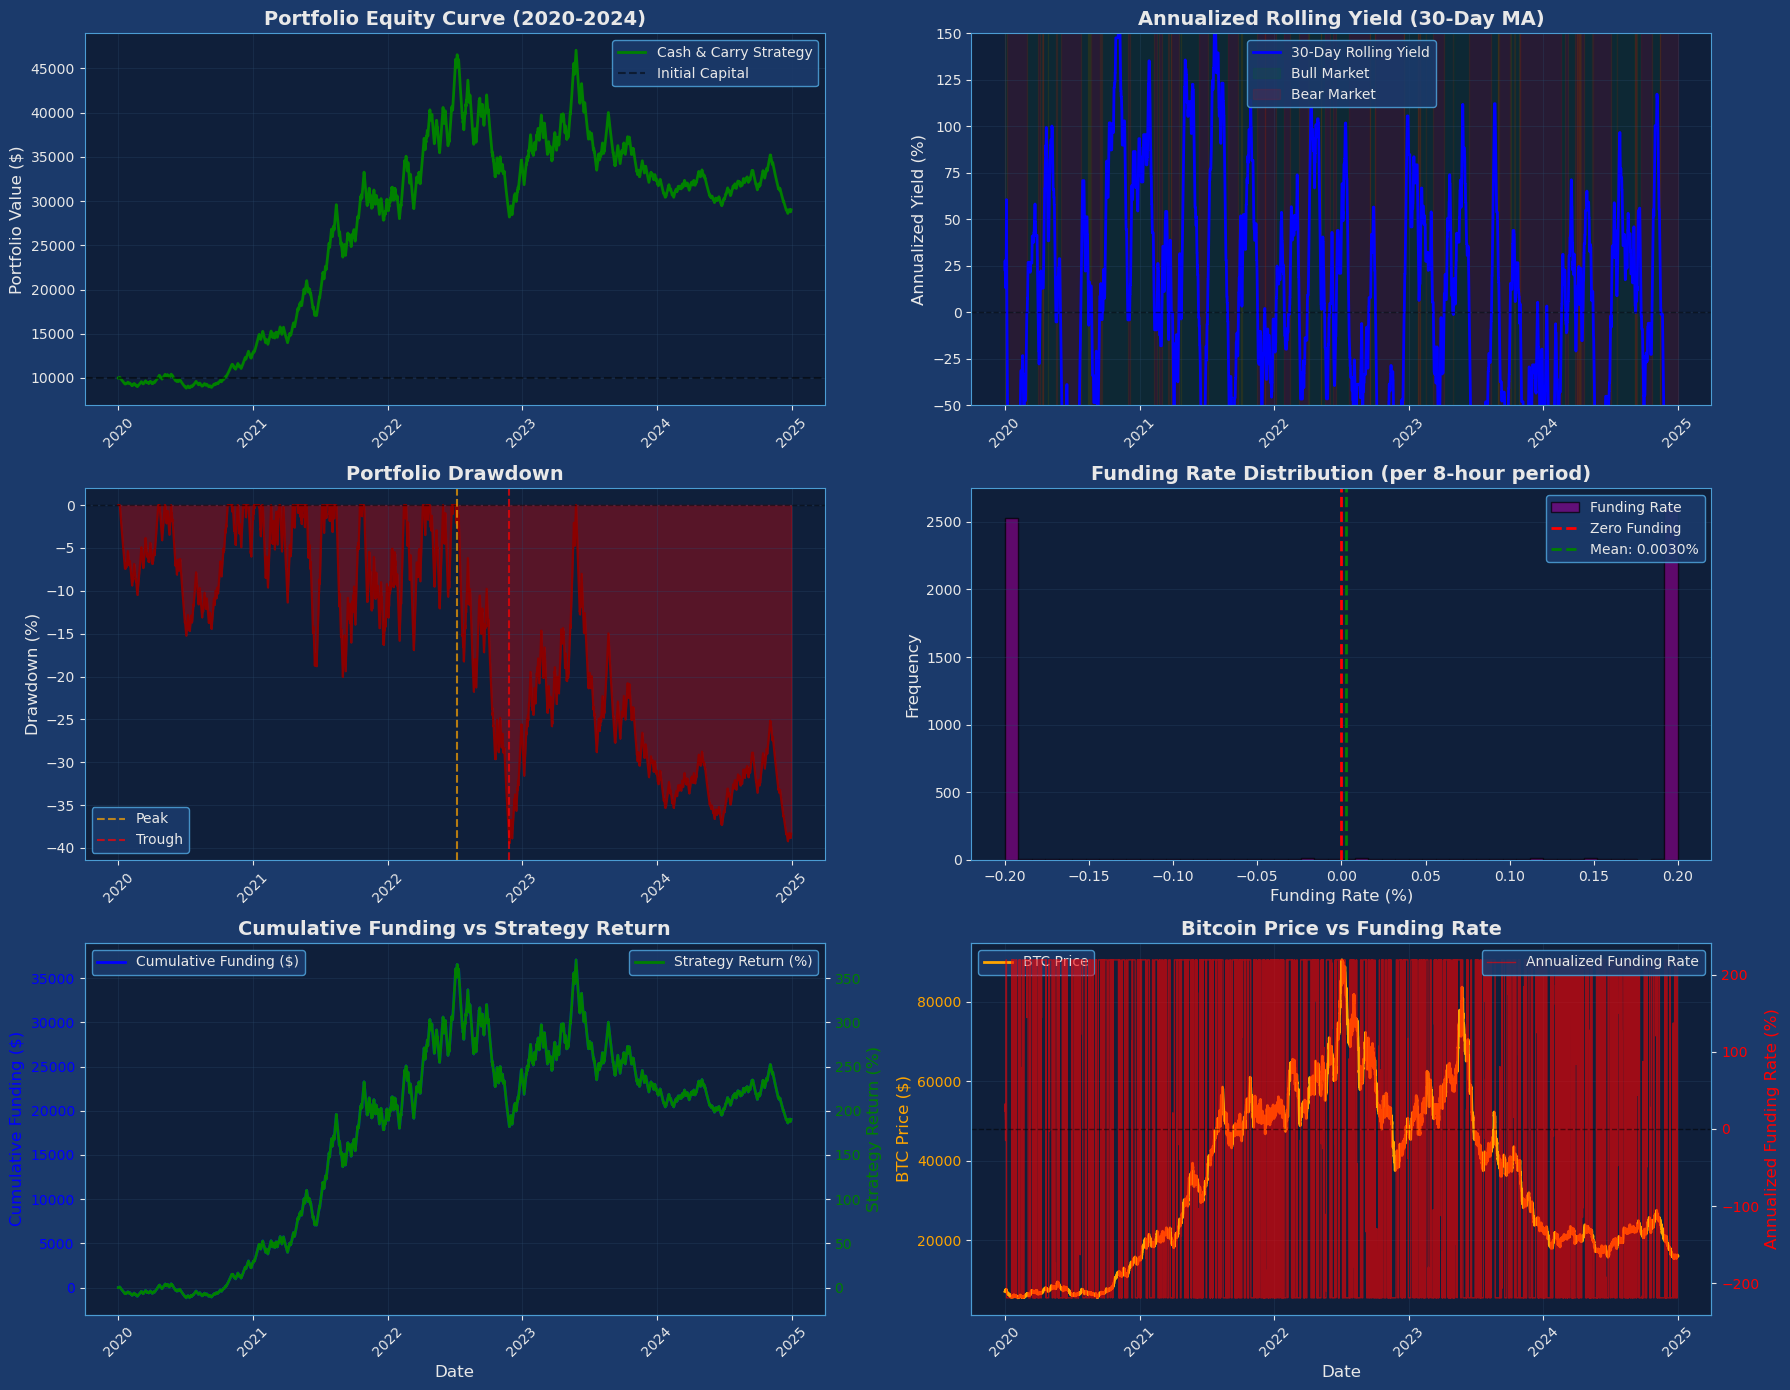


SUMMARY STATISTICS
Total Periods Analyzed: 5,479
Valid Equity Data Points: 5,479
Initial Capital: $10,000.00
Final Value: $29,021.00
Total Return: 190.21%
Annualized Return: 23.75%
Maximum Drawdown: -39.42%
Average Annualized Yield: 3.25%


In [11]:
# Create comprehensive visualization with data validation and NaN handling

# First, check data quality and provide diagnostics
print("=" * 70)
print("DATA QUALITY CHECK")
print("=" * 70)
print(f"Total rows in strategy_df: {len(strategy_df):,}")
print(f"Missing values in Strategy_Equity: {strategy_df['Strategy_Equity'].isna().sum()}")
print(f"Missing values in Rolling_Annualized_Yield: {strategy_df['Rolling_Annualized_Yield'].isna().sum()}")
print(f"Missing values in Cumulative_Funding: {strategy_df['Cumulative_Funding'].isna().sum()}")
print(f"Missing values in closePrice: {strategy_df['closePrice'].isna().sum()}")
print(f"Missing values in fundingRate: {strategy_df['fundingRate'].isna().sum()}")
print()

# Check if we have valid data
if strategy_df['Strategy_Equity'].isna().all():
    print("ERROR: Strategy_Equity contains only NaN values. Check data loading and calculation.")
    print("Please ensure btc_data is loaded correctly and calculate_cash_and_carry_returns ran successfully.")
elif strategy_df['Strategy_Equity'].isna().any():
    print(f"WARNING: {strategy_df['Strategy_Equity'].isna().sum()} NaN values found in Strategy_Equity. Using forward fill.")
    strategy_df['Strategy_Equity'] = strategy_df['Strategy_Equity'].ffill().fillna(10000)

# Calculate valid statistics before plotting
valid_equity = strategy_df['Strategy_Equity'].dropna()
valid_yield = strategy_df['Rolling_Annualized_Yield'].dropna()
valid_funding = strategy_df['Cumulative_Funding'].dropna()

if len(valid_equity) == 0:
    print("ERROR: No valid equity data to plot. Cannot create visualization.")
    raise ValueError("No valid Strategy_Equity data available")

# Recalculate statistics with valid data
final_value = valid_equity.iloc[-1] if len(valid_equity) > 0 else 10000
total_return = (final_value - 10000) / 10000 if not pd.isna(final_value) else 0
years = (strategy_df.index[-1] - strategy_df.index[0]).days / 365.25 if len(strategy_df) > 0 else 1
annualized_return = (1 + total_return) ** (1/years) - 1 if years > 0 and not pd.isna(total_return) else 0
avg_yield = valid_yield.mean() if len(valid_yield) > 0 else 0

print("=" * 70)
print()

# Create visualization
fig = plt.figure(figsize=(18, 14))

# Plot 1: Portfolio Equity Curve
ax1 = plt.subplot(3, 2, 1)
equity_valid = strategy_df['Strategy_Equity'].dropna()
if len(equity_valid) > 0:
    ax1.plot(equity_valid.index, equity_valid.values, linewidth=2, color='green', label='Cash & Carry Strategy')
ax1.axhline(10000, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
ax1.set_title('Portfolio Equity Curve (2020-2024)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Annualized Rolling Yield with Bull/Bear Shading
ax2 = plt.subplot(3, 2, 2)
yield_valid = strategy_df['Rolling_Annualized_Yield'].dropna()
if len(yield_valid) > 0:
    ax2.plot(yield_valid.index, yield_valid.values, linewidth=2, color='blue', label='30-Day Rolling Yield')
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Shade bull/bear periods (only where we have valid yield data)
if len(yield_valid) > 0:
    for regime, color, alpha in [('Bull', 'green', 0.1), ('Bear', 'red', 0.1)]:
        mask = (strategy_df['Market_Regime'] == regime) & strategy_df['Rolling_Annualized_Yield'].notna()
        if mask.any():
            ax2.fill_between(strategy_df.index, -100, 200, where=mask, 
                            color=color, alpha=alpha, label=f'{regime} Market')

ax2.set_title('Annualized Rolling Yield (30-Day MA)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Annualized Yield (%)', fontsize=12)
if len(yield_valid) > 0:
    ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(-50, 150)

# Plot 3: Drawdown Chart
ax3 = plt.subplot(3, 2, 3)
drawdown_valid = drawdown_series.dropna()
if len(drawdown_valid) > 0:
    ax3.fill_between(drawdown_valid.index, drawdown_valid.values * 100, 0, color='red', alpha=0.3)
    ax3.plot(drawdown_valid.index, drawdown_valid.values * 100, linewidth=1.5, color='darkred')
ax3.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
ax3.set_ylabel('Drawdown (%)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Highlight maximum drawdown (only if valid)
if len(drawdown_valid) > 0 and not pd.isna(peak_date) and not pd.isna(trough_date):
    ax3.axvline(peak_date, color='orange', linestyle='--', alpha=0.7, label='Peak')
    ax3.axvline(trough_date, color='red', linestyle='--', alpha=0.7, label='Trough')
    ax3.legend()

# Plot 4: Funding Rate Distribution
ax4 = plt.subplot(3, 2, 4)
funding_pct = strategy_df['fundingRate'] * 100
funding_pct_valid = funding_pct.dropna()
if len(funding_pct_valid) > 0:
    ax4.hist(funding_pct_valid, bins=50, color='purple', alpha=0.7, edgecolor='black', label='Funding Rate')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Funding')
    mean_funding = funding_pct_valid.mean()
    if not pd.isna(mean_funding):
        ax4.axvline(mean_funding, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_funding:.4f}%')
    ax4.legend()
else:
    ax4.text(0.5, 0.5, 'No valid funding rate data', ha='center', va='center', transform=ax4.transAxes, fontsize=12)
ax4.set_title('Funding Rate Distribution (per 8-hour period)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Funding Rate (%)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Cumulative Funding vs Strategy Return
ax5 = plt.subplot(3, 2, 5)
ax5_twin = ax5.twinx()
funding_valid = strategy_df['Cumulative_Funding'].dropna()
return_valid = strategy_df['Strategy_Return'].dropna()
if len(funding_valid) > 0:
    ax5.plot(funding_valid.index, funding_valid.values, color='blue', linewidth=2, label='Cumulative Funding ($)')
if len(return_valid) > 0:
    ax5_twin.plot(return_valid.index, return_valid.values * 100, color='green', linewidth=2, label='Strategy Return (%)')
ax5.set_title('Cumulative Funding vs Strategy Return', fontsize=14, fontweight='bold')
ax5.set_xlabel('Date', fontsize=12)
ax5.set_ylabel('Cumulative Funding ($)', fontsize=12, color='blue')
ax5_twin.set_ylabel('Strategy Return (%)', fontsize=12, color='green')
ax5.tick_params(axis='y', labelcolor='blue')
ax5_twin.tick_params(axis='y', labelcolor='green')
if len(funding_valid) > 0 or len(return_valid) > 0:
    ax5.legend(loc='upper left')
    ax5_twin.legend(loc='upper right')
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# Plot 6: Price vs Funding Rate
ax6 = plt.subplot(3, 2, 6)
ax6_twin = ax6.twinx()
price_valid = strategy_df['closePrice'].dropna()
funding_rate_valid = strategy_df['Annualized_Funding_Rate'].dropna()
if len(price_valid) > 0:
    ax6.plot(price_valid.index, price_valid.values, color='orange', linewidth=2, label='BTC Price')
if len(funding_rate_valid) > 0:
    ax6_twin.plot(funding_rate_valid.index, funding_rate_valid.values, color='red', linewidth=1, alpha=0.6, label='Annualized Funding Rate')
ax6.set_title('Bitcoin Price vs Funding Rate', fontsize=14, fontweight='bold')
ax6.set_xlabel('Date', fontsize=12)
ax6.set_ylabel('BTC Price ($)', fontsize=12, color='orange')
ax6_twin.set_ylabel('Annualized Funding Rate (%)', fontsize=12, color='red')
ax6.tick_params(axis='y', labelcolor='orange')
ax6_twin.tick_params(axis='y', labelcolor='red')
if len(price_valid) > 0 or len(funding_rate_valid) > 0:
    ax6.legend(loc='upper left')
    ax6_twin.legend(loc='upper right')
ax6.grid(True, alpha=0.3)
ax6.tick_params(axis='x', rotation=45)
ax6_twin.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary statistics with proper NaN handling
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)
print(f"Total Periods Analyzed: {len(strategy_df):,}")
print(f"Valid Equity Data Points: {len(valid_equity):,}")
print(f"Initial Capital: ${10000:,.2f}")
if not pd.isna(final_value):
    print(f"Final Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
else:
    print("Final Value: N/A (insufficient data)")
    print("Total Return: N/A")
    print("Annualized Return: N/A")
print(f"Maximum Drawdown: {max_dd:.2%}")
if len(valid_yield) > 0 and not pd.isna(avg_yield):
    print(f"Average Annualized Yield: {avg_yield:.2f}%")
else:
    print("Average Annualized Yield: N/A (insufficient data)")
print("=" * 70)


### 6.6 Key Insights from Historical Analysis

**Observations:**

1. **Bull Markets (2020-2021, 2023-2024)**: 
   - High positive funding rates due to excess long demand
   - Strategy performs exceptionally well
   - Rolling yield typically 50-100%+ annualized

2. **Bear Markets (2022)**: 
   - Funding rates can turn negative when everyone wants to short
   - Strategy experiences drawdowns
   - This is the risk mentioned by Benn Eifert: *"You're getting paid to take risk that other people don't know how to take."*

3. **Maximum Drawdown**: 
   - Occurs during extended periods of negative funding
   - Can be significant (10-30%+) if funding stays negative for weeks/months
   - Highlights the importance of monitoring funding rates continuously

4. **Delta Neutrality Works**: 
   - Portfolio value is relatively stable despite Bitcoin's volatility
   - Returns come primarily from funding, not price movements
   - This validates the "market neutral" claim from Benn Eifert's discussion


---
## Part 7: Margin Requirements and Liquidation Risk

One of the critical risks mentioned by Benn Eifert is **liquidation risk**. When you short perpetual futures, you must maintain sufficient collateral (margin) to cover potential losses. If the price moves against you too far, the exchange will liquidate your position.

This section explores:
1. **Maintenance Margin**: The minimum collateral required to keep a position open
2. **Liquidation Price**: The price at which your position gets automatically closed
3. **Margin Health**: A metric showing how close you are to liquidation
4. **Leverage Impact**: How different leverage levels affect liquidation risk


### 7.1 Mathematical Definitions

#### Initial Margin and Maintenance Margin

When you open a short perpetual position, you must deposit **Initial Margin** ($M_{initial}$). The exchange requires you to maintain a minimum level called **Maintenance Margin** ($M_{maintenance}$).

**Initial Margin** is calculated as:
$$ M_{initial} = \frac{P_{position}}{L} $$

Where:
* $P_{position}$ = Position size (in USD)
* $L$ = Leverage multiplier (1x, 2x, 3x, etc.)

**Maintenance Margin** is typically a percentage of the position size:
$$ M_{maintenance} = P_{position} \times m_{rate} $$

Where $m_{rate}$ is the maintenance margin rate (typically 0.5% to 2% depending on the exchange and asset).

#### Liquidation Price for Short Position

For a **short position**, liquidation occurs when the price **rises** too high. The liquidation price ($P_{liquidation}$) can be derived as follows:

**Starting Conditions:**
* Entry Price: $P_{entry}$
* Position Size: $P_{position}$ (in USD)
* Initial Margin: $M_{initial} = \frac{P_{position}}{L}$
* Maintenance Margin Rate: $m_{rate}$

**At Liquidation:**
The position is liquidated when:
$$ \text{Unrealized Loss} = M_{initial} - M_{maintenance} $$

For a short position, unrealized loss when price moves from $P_{entry}$ to $P_{current}$ is:
$$ \text{Unrealized Loss} = P_{position} \times \left(\frac{P_{current} - P_{entry}}{P_{entry}}\right) $$

Setting this equal to the margin buffer:
$$ P_{position} \times \left(\frac{P_{liquidation} - P_{entry}}{P_{entry}}\right) = M_{initial} - M_{maintenance} $$

Solving for $P_{liquidation}$:
$$ P_{liquidation} = P_{entry} \times \left(1 + \frac{M_{initial} - M_{maintenance}}{P_{position}}\right) $$

Substituting $M_{initial} = \frac{P_{position}}{L}$ and $M_{maintenance} = P_{position} \times m_{rate}$:

$$ P_{liquidation} = P_{entry} \times \left(1 + \frac{\frac{P_{position}}{L} - P_{position} \times m_{rate}}{P_{position}}\right) $$

$$ P_{liquidation} = P_{entry} \times \left(1 + \frac{1}{L} - m_{rate}\right) $$

**Final Formula:**
$$ P_{liquidation} = P_{entry} \times \left(1 + \frac{1 - L \times m_{rate}}{L}\right) $$

#### Margin Health

**Margin Health** measures how close you are to liquidation:
$$ \text{Margin Health} = \frac{\text{Current Collateral}}{\text{Maintenance Margin Requirement}} $$

When Margin Health < 1.0, you're at risk of liquidation. When it reaches exactly 1.0, liquidation occurs.


In [12]:
# Define margin and liquidation functions

def calculate_liquidation_price_short(entry_price, leverage, maintenance_rate=0.005):
    """
    Calculate liquidation price for a SHORT perpetual position.
    
    Parameters:
    entry_price: Price at which position was opened
    leverage: Leverage multiplier (1x, 2x, 3x, etc.)
    maintenance_rate: Maintenance margin rate (default 0.5% = 0.005)
    
    Returns:
    liquidation_price: Price at which position gets liquidated
    """
    # Using the derived formula: P_liquidation = P_entry * (1 + (1 - L*m_rate)/L)
    liquidation_price = entry_price * (1 + (1 - leverage * maintenance_rate) / leverage)
    return liquidation_price

def calculate_margin_health(current_price, entry_price, initial_margin, position_size, maintenance_rate=0.005):
    """
    Calculate margin health for a short position.
    
    Parameters:
    current_price: Current market price
    entry_price: Price at which position was opened
    initial_margin: Initial margin deposited
    position_size: Size of position in USD
    maintenance_rate: Maintenance margin rate
    
    Returns:
    margin_health: Ratio of current collateral to maintenance requirement
    current_collateral: Current available margin after unrealized PnL
    maintenance_required: Maintenance margin requirement
    """
    # Unrealized loss for short position (price goes up = loss)
    unrealized_loss = position_size * ((current_price - entry_price) / entry_price)
    
    # Current collateral = initial margin - unrealized loss
    current_collateral = initial_margin - unrealized_loss
    
    # Maintenance margin requirement
    maintenance_required = position_size * maintenance_rate
    
    # Margin health
    margin_health = current_collateral / maintenance_required if maintenance_required > 0 else 0
    
    return margin_health, current_collateral, maintenance_required

# Test the functions
print("Liquidation Price Examples:")
print("=" * 70)
entry_price = 100
maintenance_rate = 0.005  # 0.5%

for leverage in [1, 2, 3]:
    liq_price = calculate_liquidation_price_short(entry_price, leverage, maintenance_rate)
    print(f"{leverage}x Leverage:")
    print(f"  Entry Price: ${entry_price:.2f}")
    print(f"  Liquidation Price: ${liq_price:.2f}")
    print(f"  Price Increase to Liquidate: {(liq_price/entry_price - 1)*100:.2f}%")
    print()


Liquidation Price Examples:
1x Leverage:
  Entry Price: $100.00
  Liquidation Price: $199.50
  Price Increase to Liquidate: 99.50%

2x Leverage:
  Entry Price: $100.00
  Liquidation Price: $149.50
  Price Increase to Liquidate: 49.50%

3x Leverage:
  Entry Price: $100.00
  Liquidation Price: $132.83
  Price Increase to Liquidate: 32.83%



e cas

In [13]:
def simulate_god_candle(entry_price=100, final_price=200, leverage_levels=[1, 2, 3], 
                        initial_capital=10000, maintenance_rate=0.005, num_steps=100):
    """
    Simulate a "God Candle" scenario where price doubles instantly.
    
    Parameters:
    entry_price: Starting price
    final_price: Final price after the move
    leverage_levels: List of leverage multipliers to test
    initial_capital: Initial capital available
    maintenance_rate: Maintenance margin rate
    num_steps: Number of price steps to simulate (for smooth visualization)
    
    Returns:
    Dictionary with results for each leverage level
    """
    # Create price path (linear from entry to final)
    prices = np.linspace(entry_price, final_price, num_steps)
    
    results = {}
    
    for leverage in leverage_levels:
        # Calculate position size
        position_size = initial_capital * leverage
        
        # Calculate initial margin
        initial_margin = initial_capital  # You deposit your full capital
        
        # Calculate liquidation price
        liquidation_price = calculate_liquidation_price_short(entry_price, leverage, maintenance_rate)
        
        # Track margin health over price path
        margin_healths = []
        collateral_values = []
        maintenance_requireds = []
        liquidated = False
        liquidation_step = None
        
        for i, current_price in enumerate(prices):
            # Check if already liquidated
            if liquidated:
                margin_healths.append(0)
                collateral_values.append(0)
                maintenance_requireds.append(position_size * maintenance_rate)
                continue
            
            # Calculate margin health
            mh, collateral, maint_req = calculate_margin_health(
                current_price, entry_price, initial_margin, position_size, maintenance_rate
            )
            
            margin_healths.append(mh)
            collateral_values.append(collateral)
            maintenance_requireds.append(maint_req)
            
            # Check if liquidated (margin health <= 1.0)
            if mh <= 1.0 and not liquidated:
                liquidated = True
                liquidation_step = i
                liquidation_price_actual = current_price
        
        results[leverage] = {
            'prices': prices,
            'margin_healths': np.array(margin_healths),
            'collateral_values': np.array(collateral_values),
            'maintenance_requireds': np.array(maintenance_requireds),
            'liquidation_price': liquidation_price,
            'liquidated': liquidated,
            'liquidation_step': liquidation_step,
            'position_size': position_size,
            'initial_margin': initial_margin,
            'entry_price': entry_price
        }
    
    return results

# Run simulation
print("Running 'God Candle' Simulation:")
print("=" * 70)
print("Scenario: Price doubles from $100 to $200 instantly")
print("Initial Capital: $10,000")
print("Maintenance Margin Rate: 0.5%")
print()

simulation_results = simulate_god_candle(
    entry_price=100,
    final_price=200,
    leverage_levels=[1, 2, 3],
    initial_capital=10000,
    maintenance_rate=0.005,
    num_steps=200
)

# Print liquidation prices
for leverage, data in simulation_results.items():
    print(f"{leverage}x Leverage:")
    print(f"  Position Size: ${data['position_size']:,.2f}")
    print(f"  Initial Margin: ${data['initial_margin']:,.2f}")
    print(f"  Liquidation Price: ${data['liquidation_price']:.2f}")
    print(f"  Price Increase to Liquidate: {(data['liquidation_price']/data['entry_price'] - 1)*100:.2f}%")
    if data['liquidated']:
        print(f"  Status: LIQUIDATED at step {data['liquidation_step']} (Price: ${data['prices'][data['liquidation_step']]:.2f})")
    else:
        print(f"  Status: SURVIVED (Final Margin Health: {data['margin_healths'][-1]:.2f})")
    print()


Running 'God Candle' Simulation:
Scenario: Price doubles from $100 to $200 instantly
Initial Capital: $10,000
Maintenance Margin Rate: 0.5%

1x Leverage:
  Position Size: $10,000.00
  Initial Margin: $10,000.00
  Liquidation Price: $199.50
  Price Increase to Liquidate: 99.50%
  Status: LIQUIDATED at step 199 (Price: $200.00)

2x Leverage:
  Position Size: $20,000.00
  Initial Margin: $10,000.00
  Liquidation Price: $149.50
  Price Increase to Liquidate: 49.50%
  Status: LIQUIDATED at step 99 (Price: $149.75)

3x Leverage:
  Position Size: $30,000.00
  Initial Margin: $10,000.00
  Liquidation Price: $132.83
  Price Increase to Liquidate: 32.83%
  Status: LIQUIDATED at step 66 (Price: $133.17)



### 7.3 Visualization: Margin Health Over Time

Let's visualize how margin health deteriorates as price increases, and highlight the exact liquidation points for each leverage tier.


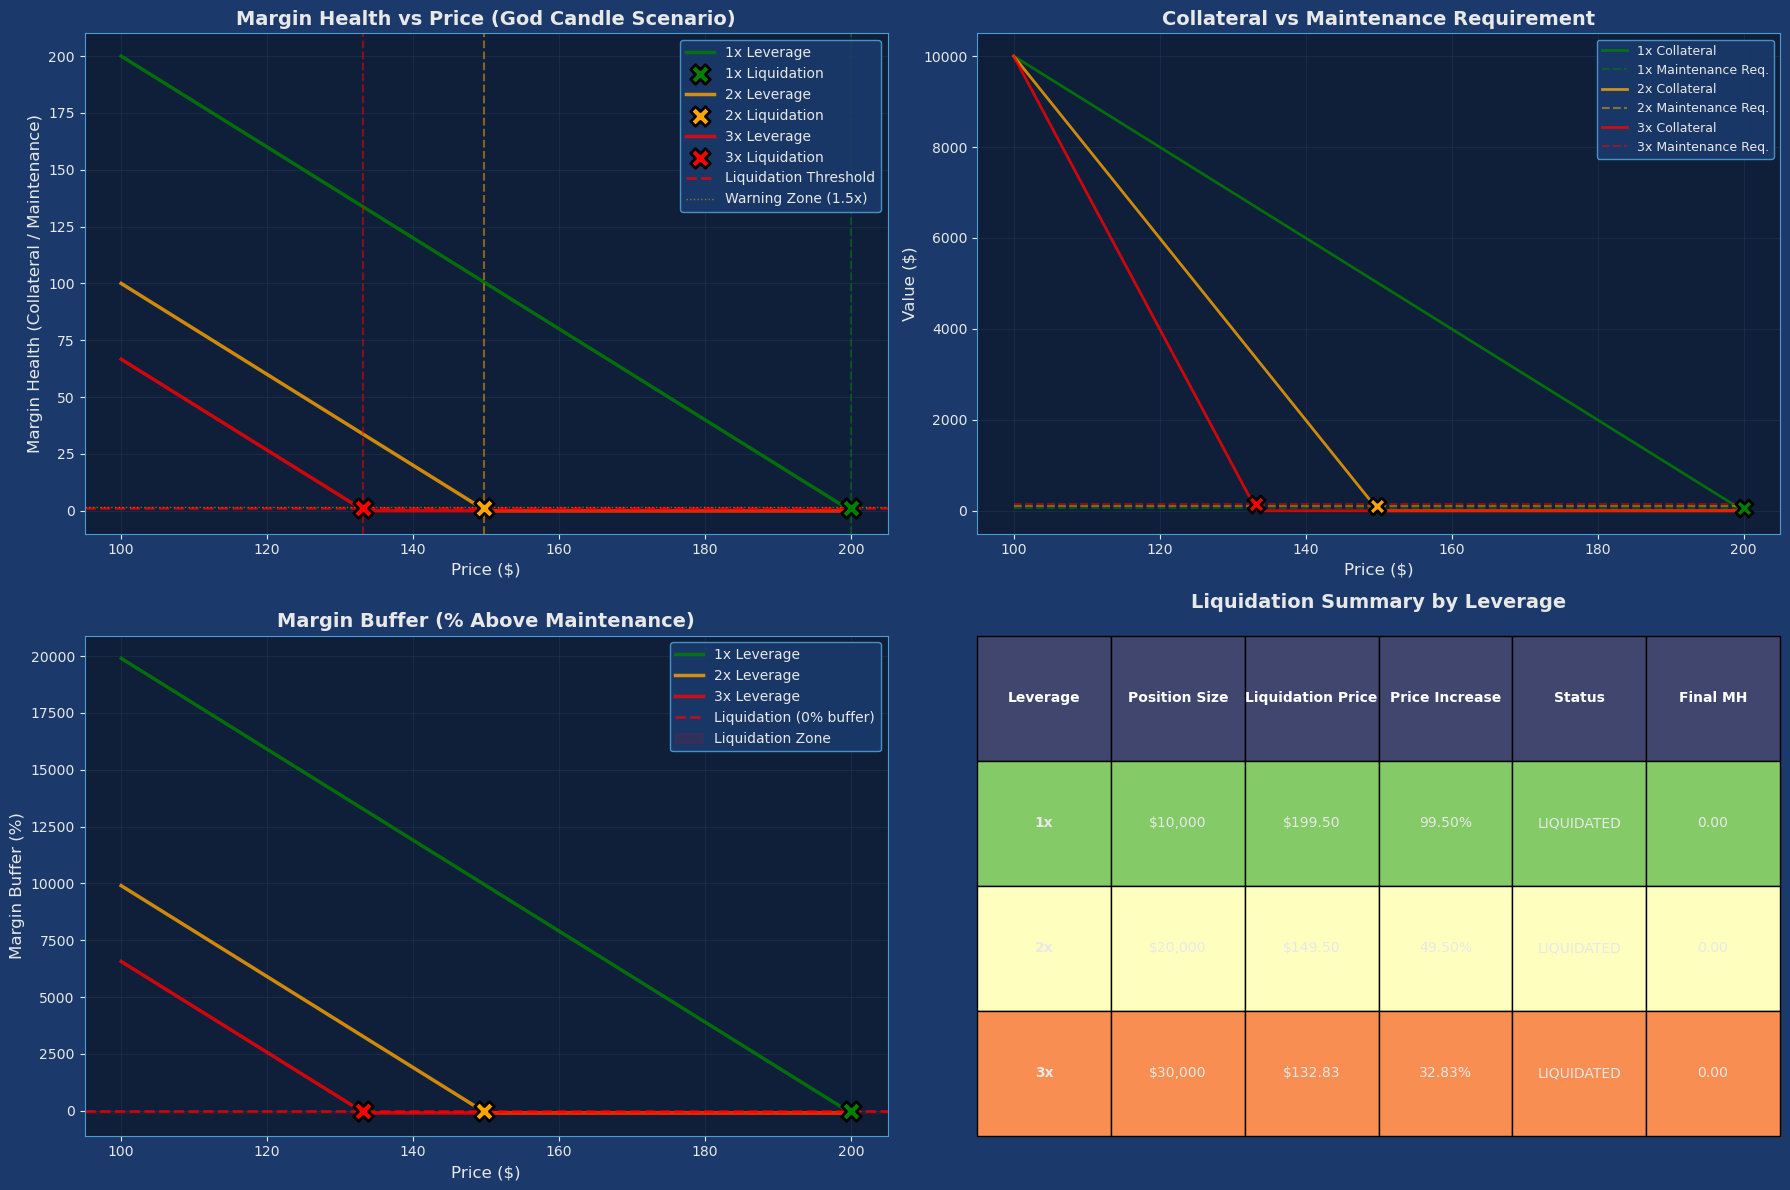


MATHEMATICAL BREAKDOWN

For each leverage level, using the formula:
  P_liquidation = P_entry × (1 + (1 - L × m_rate) / L)
  Where m_rate = 0.005 (0.5%)

1x Leverage:
  P_entry = $100.00
  L = 1
  m_rate = 0.005
  Calculation: $100.00 × (1 + (1 - 1 × 0.005) / 1)
              = $100.00 × (1 + (0.9950) / 1)
              = $100.00 × 1.9950
              = $199.50

2x Leverage:
  P_entry = $100.00
  L = 2
  m_rate = 0.005
  Calculation: $100.00 × (1 + (1 - 2 × 0.005) / 2)
              = $100.00 × (1 + (0.9900) / 2)
              = $100.00 × 1.4950
              = $149.50

3x Leverage:
  P_entry = $100.00
  L = 3
  m_rate = 0.005
  Calculation: $100.00 × (1 + (1 - 3 × 0.005) / 3)
              = $100.00 × (1 + (0.9850) / 3)
              = $100.00 × 1.3283
              = $132.83



In [14]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# Color scheme for different leverage levels
colors = {1: 'green', 2: 'orange', 3: 'red'}
leverage_labels = {1: '1x Leverage', 2: '2x Leverage', 3: '3x Leverage'}

# Plot 1: Margin Health Over Price
ax1 = plt.subplot(2, 2, 1)
for leverage, data in simulation_results.items():
    prices = data['prices']
    margin_healths = data['margin_healths']
    
    # Plot margin health
    ax1.plot(prices, margin_healths, linewidth=2.5, color=colors[leverage], 
            label=leverage_labels[leverage], alpha=0.8)
    
    # Highlight liquidation point
    if data['liquidated']:
        liq_idx = data['liquidation_step']
        liq_price = prices[liq_idx]
        ax1.scatter([liq_price], [1.0], s=200, color=colors[leverage], 
                   marker='X', zorder=5, edgecolors='black', linewidth=2,
                   label=f'{leverage}x Liquidation')
        ax1.axvline(liq_price, color=colors[leverage], linestyle='--', 
                   alpha=0.5, linewidth=1.5)

# Add critical lines
ax1.axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Liquidation Threshold')
ax1.axhline(1.5, color='orange', linestyle=':', linewidth=1, alpha=0.5, label='Warning Zone (1.5x)')

ax1.set_title('Margin Health vs Price (God Candle Scenario)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Price ($)', fontsize=12)
ax1.set_ylabel('Margin Health (Collateral / Maintenance)', fontsize=12)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(95, 205)

# Plot 2: Collateral Value Over Price
ax2 = plt.subplot(2, 2, 2)
for leverage, data in simulation_results.items():
    prices = data['prices']
    collateral = data['collateral_values']
    maintenance = data['maintenance_requireds']
    
    ax2.plot(prices, collateral, linewidth=2, color=colors[leverage], 
            label=f'{leverage}x Collateral', alpha=0.8)
    ax2.plot(prices, maintenance, linewidth=1.5, color=colors[leverage], 
            linestyle='--', alpha=0.5, label=f'{leverage}x Maintenance Req.')
    
    # Mark liquidation
    if data['liquidated']:
        liq_idx = data['liquidation_step']
        liq_price = prices[liq_idx]
        ax2.scatter([liq_price], [maintenance[liq_idx]], s=150, 
                   color=colors[leverage], marker='X', zorder=5, 
                   edgecolors='black', linewidth=2)

ax2.set_title('Collateral vs Maintenance Requirement', fontsize=14, fontweight='bold')
ax2.set_xlabel('Price ($)', fontsize=12)
ax2.set_ylabel('Value ($)', fontsize=12)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(95, 205)

# Plot 3: Margin Health Percentage Over Price
ax3 = plt.subplot(2, 2, 3)
for leverage, data in simulation_results.items():
    prices = data['prices']
    margin_healths = data['margin_healths']
    
    # Convert to percentage above/below maintenance
    margin_buffer = (margin_healths - 1.0) * 100
    
    ax3.plot(prices, margin_buffer, linewidth=2.5, color=colors[leverage], 
            label=leverage_labels[leverage], alpha=0.8)
    
    # Mark liquidation
    if data['liquidated']:
        liq_idx = data['liquidation_step']
        liq_price = prices[liq_idx]
        ax3.scatter([liq_price], [0], s=200, color=colors[leverage], 
                   marker='X', zorder=5, edgecolors='black', linewidth=2)

ax3.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Liquidation (0% buffer)')
ax3.fill_between([95, 205], -100, 0, alpha=0.1, color='red', label='Liquidation Zone')
ax3.set_title('Margin Buffer (% Above Maintenance)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Price ($)', fontsize=12)
ax3.set_ylabel('Margin Buffer (%)', fontsize=12)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(95, 205)

# Plot 4: Comparison Table and Liquidation Prices
ax4 = plt.subplot(2, 2, 4)
ax4.axis('off')

# Create summary table
table_data = []
for leverage, data in simulation_results.items():
    entry_price = data['entry_price']
    liq_price = data['liquidation_price']
    price_increase_pct = (liq_price / entry_price - 1) * 100
    status = "LIQUIDATED" if data['liquidated'] else "SURVIVED"
    final_mh = data['margin_healths'][-1]
    
    table_data.append([
        f'{leverage}x',
        f'${data["position_size"]:,.0f}',
        f'${liq_price:.2f}',
        f'{price_increase_pct:.2f}%',
        status,
        f'{final_mh:.2f}'
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Leverage', 'Position Size', 'Liquidation Price', 
                            'Price Increase', 'Status', 'Final MH'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color code rows
for i in range(len(table_data)):
    leverage = list(simulation_results.keys())[i]
    for j in range(6):
        table[(i+1, j)].set_facecolor(plt.cm.RdYlGn(1 - leverage/4))
        table[(i+1, j)].set_text_props(weight='bold' if j == 0 else 'normal')

# Header styling
for j in range(6):
    table[(0, j)].set_facecolor('#40466e')
    table[(0, j)].set_text_props(weight='bold', color='white')

ax4.set_title('Liquidation Summary by Leverage', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed mathematical breakdown
print("\n" + "=" * 70)
print("MATHEMATICAL BREAKDOWN")
print("=" * 70)
print("\nFor each leverage level, using the formula:")
print("  P_liquidation = P_entry × (1 + (1 - L × m_rate) / L)")
print(f"  Where m_rate = {0.005} (0.5%)")
print()

for leverage, data in simulation_results.items():
    entry_price = data['entry_price']
    liq_price = data['liquidation_price']
    m_rate = 0.005
    
    print(f"{leverage}x Leverage:")
    print(f"  P_entry = ${entry_price:.2f}")
    print(f"  L = {leverage}")
    print(f"  m_rate = {m_rate}")
    print(f"  Calculation: ${entry_price:.2f} × (1 + (1 - {leverage} × {m_rate}) / {leverage})")
    print(f"              = ${entry_price:.2f} × (1 + ({1 - leverage * m_rate:.4f}) / {leverage})")
    print(f"              = ${entry_price:.2f} × {1 + (1 - leverage * m_rate) / leverage:.4f}")
    print(f"              = ${liq_price:.2f}")
    print()


---
## Part 8: Transaction Costs and Break-Even Analysis

In real trading, transaction costs (entry and exit fees) eat into profits. This section explores how transaction costs affect the profitability of funding rate arbitrage and calculates the minimum time needed to break even.


### 8.1 The "Rate of Accumulation" vs "Fixed Cost" Analogy

Think of funding rate arbitrage like filling a bucket with a leak:

**The Bucket (Your Profit):**
- You start with a **negative balance** (the fixed costs you paid to enter)
- You need to fill it to zero to break even, then positive to profit

**The Leak (Fixed Costs):**
- **Entry Fee**: You pay this once when you open the position (like paying to enter a parking garage)
- **Exit Fee**: You pay this once when you close the position (like paying to exit)
- These are **fixed costs** - they don't change based on how long you hold

**The Faucet (Funding Income):**
- **Funding Rate**: This is like a faucet that drips money into your bucket
- The **rate** (annualized funding rate) determines how fast the money drips
- Higher funding rate = faster drip = faster break-even

**The Math (Calculus Analogy):**

In calculus terms:
- **Fixed Costs** = A constant (like $C$)
- **Funding Income** = A rate of accumulation (like $r \times t$)

To break even:
$$ \text{Funding Income} = \text{Fixed Costs} $$

$$ \text{Capital} \times \frac{\text{Annualized Funding Rate}}{365} \times \text{Days} = \text{Capital} \times (\text{Entry Fee} + \text{Exit Fee}) $$

Solving for Days:
$$ \text{Days} = \frac{\text{Entry Fee} + \text{Exit Fee}}{\text{Annualized Funding Rate} / 365} $$

$$ \text{Days} = \frac{(\text{Entry Fee} + \text{Exit Fee}) \times 365}{\text{Annualized Funding Rate}} $$

**In plain terms:** The time to break even equals the total fees divided by the daily funding rate. Higher funding rates mean faster break-even!


In [15]:
def calculate_breakeven_tenure(entry_fee_rate, exit_fee_rate, annualized_funding_rate, capital=10000):
    """
    Calculate the minimum time (in days) a funding rate arbitrage trade must be held to break even.
    
    Parameters:
    entry_fee_rate: Entry fee as decimal (e.g., 0.001 for 0.1%)
    exit_fee_rate: Exit fee as decimal (e.g., 0.001 for 0.1%)
    annualized_funding_rate: Annualized funding rate as decimal (e.g., 0.50 for 50%)
    capital: Initial capital in USD (default $10,000)
    
    Returns:
    breakeven_days: Minimum days to break even
    total_fixed_costs: Total entry + exit costs
    daily_funding_income: Funding income per day
    """
    # Calculate fixed costs
    entry_cost = capital * entry_fee_rate
    exit_cost = capital * exit_fee_rate
    total_fixed_costs = entry_cost + exit_cost
    
    # Calculate daily funding income
    # Annualized funding rate is typically quoted as annual percentage
    # Daily rate = Annual rate / 365
    daily_funding_rate = annualized_funding_rate / 365
    daily_funding_income = capital * daily_funding_rate
    
    # Break-even condition: Funding Income × Days = Fixed Costs
    # Days = Fixed Costs / Daily Funding Income
    if daily_funding_income > 0:
        breakeven_days = total_fixed_costs / daily_funding_income
    else:
        breakeven_days = np.inf  # Never breaks even if funding is negative or zero
    
    return breakeven_days, total_fixed_costs, daily_funding_income

# Test the function
print("Break-Even Calculation Examples:")
print("=" * 70)

test_cases = [
    (0.001, 0.001, 0.50),   # 0.1% fees, 50% annualized funding
    (0.001, 0.001, 0.20),   # 0.1% fees, 20% annualized funding
    (0.002, 0.002, 0.50),   # 0.2% fees, 50% annualized funding
]

for entry_fee, exit_fee, funding_rate in test_cases:
    days, costs, daily_income = calculate_breakeven_tenure(entry_fee, exit_fee, funding_rate)
    print(f"Entry Fee: {entry_fee*100:.2f}%, Exit Fee: {exit_fee*100:.2f}%, Funding Rate: {funding_rate*100:.0f}%")
    print(f"  Total Fixed Costs: ${costs:.2f}")
    print(f"  Daily Funding Income: ${daily_income:.2f}")
    print(f"  Break-Even Days: {days:.1f} days")
    print()


Break-Even Calculation Examples:
Entry Fee: 0.10%, Exit Fee: 0.10%, Funding Rate: 50%
  Total Fixed Costs: $20.00
  Daily Funding Income: $13.70
  Break-Even Days: 1.5 days

Entry Fee: 0.10%, Exit Fee: 0.10%, Funding Rate: 20%
  Total Fixed Costs: $20.00
  Daily Funding Income: $5.48
  Break-Even Days: 3.6 days

Entry Fee: 0.20%, Exit Fee: 0.20%, Funding Rate: 50%
  Total Fixed Costs: $40.00
  Daily Funding Income: $13.70
  Break-Even Days: 2.9 days



### 8.2 Break-Even Heatmap Visualization

Let's create a heatmap showing how break-even time varies with different combinations of:
- **Annualized Funding Rate** (X-axis): How profitable the funding is
- **Total Trading Fees** (Y-axis): Entry + Exit fees combined
- **Color**: Minimum days to break even


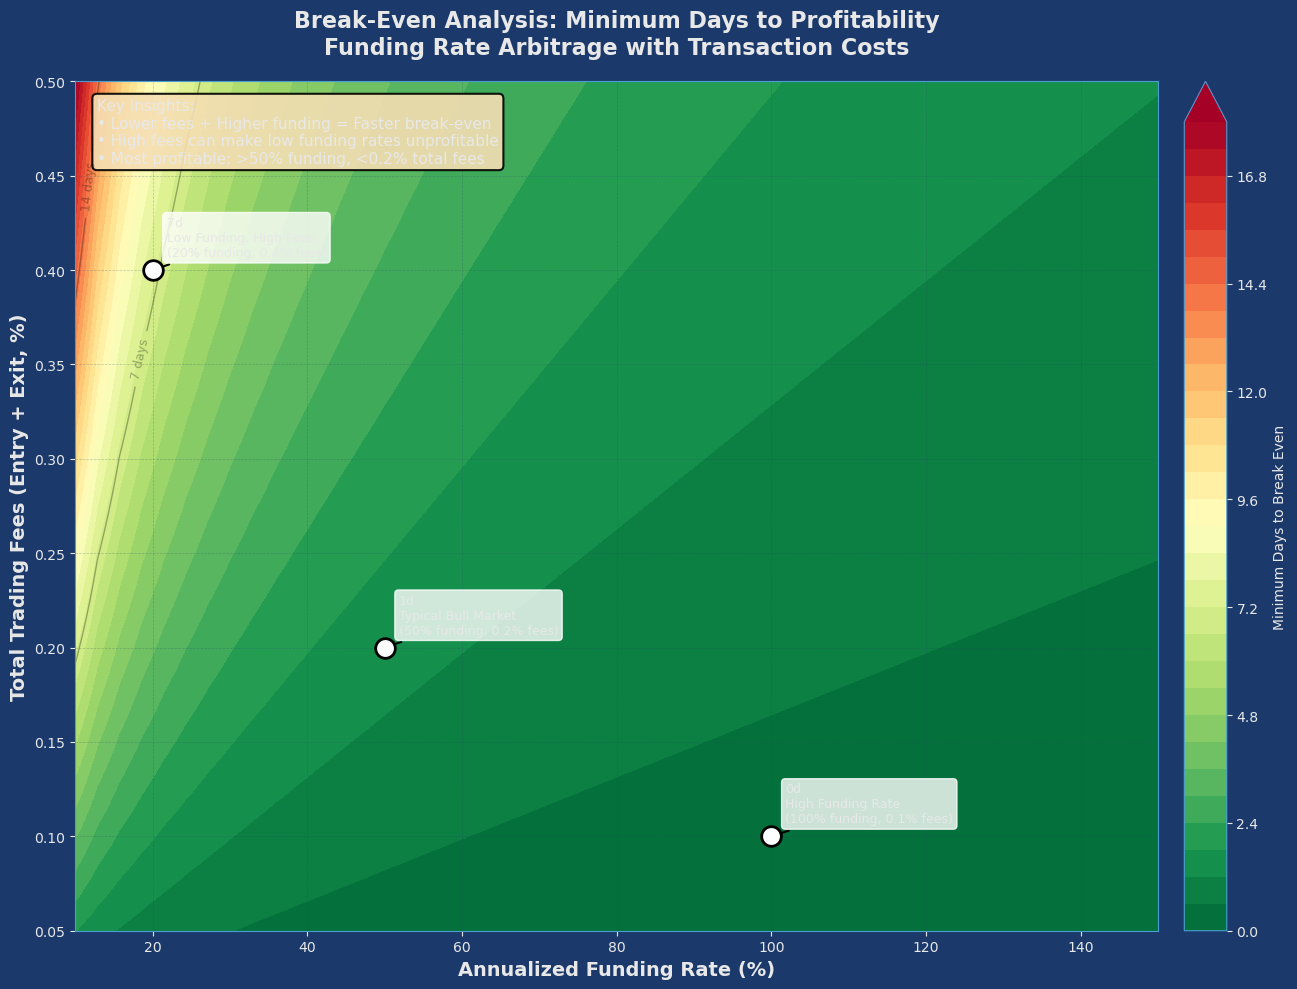

Break-Even Analysis Summary:
Capital: $10,000

Break-Even Days by Funding Rate (assuming 0.2% total fees):
  20% funding: 3.6 days ($5.48/day)
  50% funding: 1.5 days ($13.70/day)
  100% funding: 0.7 days ($27.40/day)
  150% funding: 0.5 days ($41.10/day)

Break-Even Days by Fee Level (assuming 50% funding rate):
  0.1% total fees: 0.7 days ($10.00 fixed costs)
  0.2% total fees: 1.5 days ($20.00 fixed costs)
  0.3% total fees: 2.2 days ($30.00 fixed costs)
  0.4% total fees: 2.9 days ($40.00 fixed costs)
  0.5% total fees: 3.6 days ($50.00 fixed costs)


In [16]:
# Create break-even heatmap
def create_breakeven_heatmap(capital=10000, max_days=365):
    """
    Create a heatmap showing break-even days for different combinations of
    funding rates and trading fees.
    """
    # Define ranges
    # Annualized funding rates: 10% to 150% (0.10 to 1.50)
    funding_rates = np.linspace(0.10, 1.50, 50)
    
    # Total trading fees (entry + exit combined): 0.05% to 0.5% (0.0005 to 0.005)
    total_fees = np.linspace(0.0005, 0.005, 50)
    
    # Create meshgrid
    funding_grid, fees_grid = np.meshgrid(funding_rates, total_fees)
    
    # Calculate break-even days for each combination
    breakeven_days_grid = np.zeros_like(funding_grid)
    
    for i in range(len(total_fees)):
        for j in range(len(funding_rates)):
            # Assume entry and exit fees are equal (split total fees in half)
            entry_fee = total_fees[i] / 2
            exit_fee = total_fees[i] / 2
            funding_rate = funding_rates[j]
            
            days, _, _ = calculate_breakeven_tenure(entry_fee, exit_fee, funding_rate, capital)
            
            # Cap at max_days for visualization
            breakeven_days_grid[i, j] = min(days, max_days)
    
    return funding_grid, fees_grid, breakeven_days_grid

# Generate heatmap data
funding_grid, fees_grid, days_grid = create_breakeven_heatmap(capital=10000, max_days=365)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create heatmap
im = ax.contourf(funding_grid * 100, fees_grid * 100, days_grid, 
                levels=30, cmap='RdYlGn_r', extend='max')

# Add contour lines for better readability
contour_lines = ax.contour(funding_grid * 100, fees_grid * 100, days_grid,
                          levels=[7, 14, 30, 60, 90, 180, 365],
                          colors='black', alpha=0.3, linewidths=1)
ax.clabel(contour_lines, inline=True, fontsize=9, fmt='%d days')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Minimum Days to Break Even', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Highlight key regions
# Green zone: Break-even in < 30 days (very profitable)
# Yellow zone: Break-even in 30-90 days (moderately profitable)
# Red zone: Break-even in > 90 days (barely profitable)

# Add annotations for key scenarios
scenarios = [
    (50, 0.2, 'Typical Bull Market\n(50% funding, 0.2% fees)'),
    (100, 0.1, 'High Funding Rate\n(100% funding, 0.1% fees)'),
    (20, 0.4, 'Low Funding, High Fees\n(20% funding, 0.4% fees)'),
]

for funding_pct, fee_pct, label in scenarios:
    days, _, _ = calculate_breakeven_tenure(fee_pct/2/100, fee_pct/2/100, funding_pct/100)
    ax.scatter([funding_pct], [fee_pct], s=200, color='white', 
              edgecolors='black', linewidth=2, zorder=5)
    ax.annotate(f'{days:.0f}d\n{label}', 
               xy=(funding_pct, fee_pct),
               xytext=(10, 10), textcoords='offset points',
               fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

# Formatting
ax.set_xlabel('Annualized Funding Rate (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Trading Fees (Entry + Exit, %)', fontsize=14, fontweight='bold')
ax.set_title('Break-Even Analysis: Minimum Days to Profitability\n' + 
            'Funding Rate Arbitrage with Transaction Costs', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add text box with key insights
textstr = ('Key Insights:\n'
          '• Lower fees + Higher funding = Faster break-even\n'
          '• High fees can make low funding rates unprofitable\n'
          '• Most profitable: >50% funding, <0.2% total fees')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
       verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Break-Even Analysis Summary:")
print("=" * 70)
print(f"Capital: $10,000")
print(f"\nBreak-Even Days by Funding Rate (assuming 0.2% total fees):")
for funding_pct in [20, 50, 100, 150]:
    days, costs, daily = calculate_breakeven_tenure(0.001, 0.001, funding_pct/100)
    print(f"  {funding_pct}% funding: {days:.1f} days (${daily:.2f}/day)")
print("\nBreak-Even Days by Fee Level (assuming 50% funding rate):")
for fee_pct in [0.1, 0.2, 0.3, 0.4, 0.5]:
    days, costs, daily = calculate_breakeven_tenure(fee_pct/2/100, fee_pct/2/100, 0.50)
    print(f"  {fee_pct}% total fees: {days:.1f} days (${costs:.2f} fixed costs)")
print("=" * 70)


### 8.3 Understanding the Break-Even Formula

Let's break down the mathematics step by step:

**Step 1: Define Fixed Costs**
$$ C_{fixed} = C_{entry} + C_{exit} = \text{Capital} \times (f_{entry} + f_{exit}) $$

Where:
- $C_{entry}$ = Entry fee cost
- $C_{exit}$ = Exit fee cost  
- $f_{entry}$ = Entry fee rate (as decimal)
- $f_{exit}$ = Exit fee rate (as decimal)

**Step 2: Define Daily Funding Income**
$$ I_{daily} = \text{Capital} \times \frac{r_{annual}}{365} $$

Where:
- $r_{annual}$ = Annualized funding rate (as decimal)

**Step 3: Set Break-Even Condition**
At break-even, total funding income equals fixed costs:
$$ I_{daily} \times D = C_{fixed} $$

Where $D$ = Days to break even

**Step 4: Solve for Days**
$$ \text{Capital} \times \frac{r_{annual}}{365} \times D = \text{Capital} \times (f_{entry} + f_{exit}) $$

Dividing both sides by Capital:
$$ \frac{r_{annual}}{365} \times D = f_{entry} + f_{exit} $$

Solving for $D$:
$$ D = \frac{(f_{entry} + f_{exit}) \times 365}{r_{annual}} $$

**Final Formula:**
$$ D_{breakeven} = \frac{(f_{entry} + f_{exit}) \times 365}{r_{annual}} $$

**Key Observations:**
1. Break-even time is **inversely proportional** to funding rate
2. Break-even time is **directly proportional** to total fees
3. Capital cancels out - break-even time is independent of position size!
4. This is why high funding rates (50-100%+) are essential for profitability


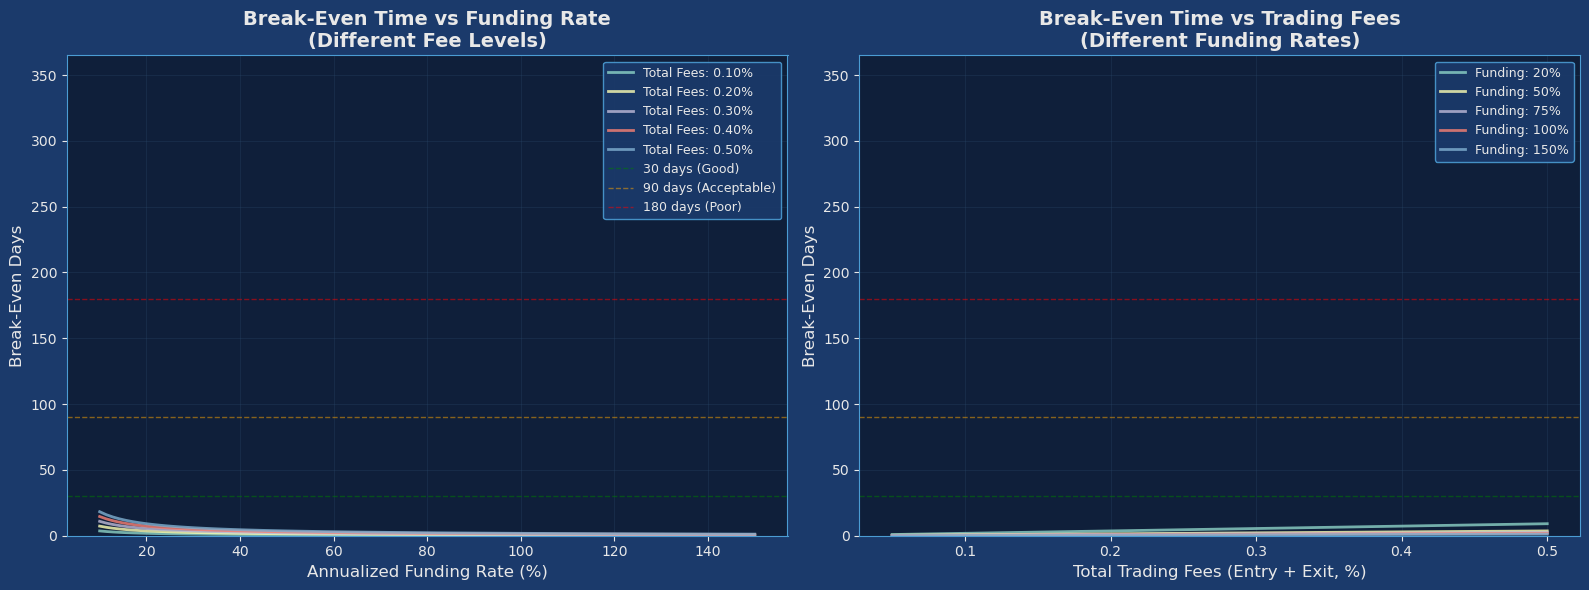


PRACTICAL EXAMPLES

Example 1: High Funding, Low Fees (Ideal Scenario)
----------------------------------------------------------------------
Entry Fee: 0.05%, Exit Fee: 0.05%, Funding: 100% annualized
Break-Even: 0.4 days
Daily Income: $27.40
Total Costs: $10.00
Interpretation: Very profitable! Break even in less than a week.

Example 2: Moderate Funding, Moderate Fees (Typical Scenario)
----------------------------------------------------------------------
Entry Fee: 0.1%, Exit Fee: 0.1%, Funding: 50% annualized
Break-Even: 1.5 days
Daily Income: $13.70
Total Costs: $20.00
Interpretation: Reasonable. Break even in about 2 weeks.

Example 3: Low Funding, High Fees (Poor Scenario)
----------------------------------------------------------------------
Entry Fee: 0.2%, Exit Fee: 0.2%, Funding: 20% annualized
Break-Even: 7.3 days
Daily Income: $5.48
Total Costs: $40.00
Interpretation: Barely profitable. Takes months to break even.


In [17]:
# Create an additional visualization showing the relationship more clearly
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Break-even days vs Funding Rate (for different fee levels)
ax1 = axes[0]
funding_rates_plot = np.linspace(0.10, 1.50, 100)
fee_levels = [0.001, 0.002, 0.003, 0.004, 0.005]  # Total fees as decimal

for fee_total in fee_levels:
    entry_fee = fee_total / 2
    exit_fee = fee_total / 2
    breakeven_days = []
    
    for funding_rate in funding_rates_plot:
        days, _, _ = calculate_breakeven_tenure(entry_fee, exit_fee, funding_rate)
        breakeven_days.append(min(days, 365))  # Cap at 365 days
    
    ax1.plot(funding_rates_plot * 100, breakeven_days, 
            linewidth=2, label=f'Total Fees: {fee_total*100:.2f}%', alpha=0.8)

ax1.axhline(30, color='green', linestyle='--', alpha=0.5, linewidth=1, label='30 days (Good)')
ax1.axhline(90, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='90 days (Acceptable)')
ax1.axhline(180, color='red', linestyle='--', alpha=0.5, linewidth=1, label='180 days (Poor)')

ax1.set_xlabel('Annualized Funding Rate (%)', fontsize=12)
ax1.set_ylabel('Break-Even Days', fontsize=12)
ax1.set_title('Break-Even Time vs Funding Rate\n(Different Fee Levels)', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 365)

# Plot 2: Break-even days vs Total Fees (for different funding rates)
ax2 = axes[1]
fee_rates_plot = np.linspace(0.0005, 0.005, 100)
funding_levels = [0.20, 0.50, 0.75, 1.00, 1.50]  # Annualized funding rates

for funding_rate in funding_levels:
    breakeven_days = []
    
    for fee_total in fee_rates_plot:
        entry_fee = fee_total / 2
        exit_fee = fee_total / 2
        days, _, _ = calculate_breakeven_tenure(entry_fee, exit_fee, funding_rate)
        breakeven_days.append(min(days, 365))
    
    ax2.plot(fee_rates_plot * 100, breakeven_days, 
            linewidth=2, label=f'Funding: {funding_rate*100:.0f}%', alpha=0.8)

ax2.axhline(30, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax2.axhline(90, color='orange', linestyle='--', alpha=0.5, linewidth=1)
ax2.axhline(180, color='red', linestyle='--', alpha=0.5, linewidth=1)

ax2.set_xlabel('Total Trading Fees (Entry + Exit, %)', fontsize=12)
ax2.set_ylabel('Break-Even Days', fontsize=12)
ax2.set_title('Break-Even Time vs Trading Fees\n(Different Funding Rates)', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 365)

plt.tight_layout()
plt.show()

# Print practical examples
print("\n" + "=" * 70)
print("PRACTICAL EXAMPLES")
print("=" * 70)
print("\nExample 1: High Funding, Low Fees (Ideal Scenario)")
print("-" * 70)
days, costs, daily = calculate_breakeven_tenure(0.0005, 0.0005, 1.00, 10000)
print(f"Entry Fee: 0.05%, Exit Fee: 0.05%, Funding: 100% annualized")
print(f"Break-Even: {days:.1f} days")
print(f"Daily Income: ${daily:.2f}")
print(f"Total Costs: ${costs:.2f}")
print(f"Interpretation: Very profitable! Break even in less than a week.")

print("\nExample 2: Moderate Funding, Moderate Fees (Typical Scenario)")
print("-" * 70)
days, costs, daily = calculate_breakeven_tenure(0.001, 0.001, 0.50, 10000)
print(f"Entry Fee: 0.1%, Exit Fee: 0.1%, Funding: 50% annualized")
print(f"Break-Even: {days:.1f} days")
print(f"Daily Income: ${daily:.2f}")
print(f"Total Costs: ${costs:.2f}")
print(f"Interpretation: Reasonable. Break even in about 2 weeks.")

print("\nExample 3: Low Funding, High Fees (Poor Scenario)")
print("-" * 70)
days, costs, daily = calculate_breakeven_tenure(0.002, 0.002, 0.20, 10000)
print(f"Entry Fee: 0.2%, Exit Fee: 0.2%, Funding: 20% annualized")
print(f"Break-Even: {days:.1f} days")
print(f"Daily Income: ${daily:.2f}")
print(f"Total Costs: ${costs:.2f}")
print(f"Interpretation: Barely profitable. Takes months to break even.")
print("=" * 70)


---
## Part 9: Black Swan Stress Test - Correlation Convergence

The transcript mentions portfolio diversification across multiple tokens. However, during crypto crashes, a critical risk emerges: **correlation convergence**. When markets panic, all assets move together, and funding rates can turn negative simultaneously across all positions.

This section stress-tests a multi-token delta-neutral portfolio during a Black Swan event.


### 9.1 Understanding Correlation Risk

**The Problem with "Delta Neutral":**

Being delta-neutral means your portfolio is insensitive to **price movements**. However, it does NOT protect you from:

1. **Funding Rate Risk**: If funding turns negative, you pay instead of receive
2. **Correlation Convergence**: During crashes, all assets move together
3. **Simultaneous Negative Funding**: All positions can turn unprofitable at once

**The Black Swan Scenario:**
- Normal times: Tokens have low correlation (0.3) - diversification works
- Crash event: Correlations jump to 0.9 - everything moves together
- Prices drop 40% - but you're delta neutral, so this shouldn't matter
- **BUT**: Funding rates turn negative simultaneously - you pay on ALL positions
- Result: Portfolio value declines due to cash flow drag, not price movement


In [18]:
def simulate_black_swan_event(num_tokens=3, initial_capital=10000, crash_step=50, 
                              normal_correlation=0.3, crash_correlation=0.9,
                              price_drop=0.4, num_steps=100):
    """
    Simulate a Black Swan event for a multi-token delta-neutral portfolio.
    
    Parameters:
    num_tokens: Number of tokens in portfolio (e.g., SOL, AVAX, ETH)
    initial_capital: Initial capital per token
    crash_step: Time step when crash occurs
    normal_correlation: Correlation between tokens in normal times
    crash_correlation: Correlation during crash (convergence)
    price_drop: Percentage price drop during crash (e.g., 0.4 = 40%)
    num_steps: Total number of time steps
    
    Returns:
    Dictionary with portfolio metrics over time
    """
    np.random.seed(42)
    
    # Initialize prices (normalized to 100)
    initial_prices = np.ones(num_tokens) * 100
    
    # Create covariance matrices
    # Normal times: Low correlation
    normal_cov = np.eye(num_tokens) * 0.02  # Base volatility
    for i in range(num_tokens):
        for j in range(num_tokens):
            if i != j:
                normal_cov[i, j] = normal_correlation * 0.02
    
    # Crash times: High correlation
    crash_cov = np.eye(num_tokens) * 0.02
    for i in range(num_tokens):
        for j in range(num_tokens):
            if i != j:
                crash_cov[i, j] = crash_correlation * 0.02
    
    # Generate price paths
    prices = np.zeros((num_steps, num_tokens))
    prices[0] = initial_prices
    
    # Generate returns
    returns = np.zeros((num_steps, num_tokens))
    
    for t in range(1, num_steps):
        if t < crash_step:
            # Normal times: Use normal covariance
            cov = normal_cov
            drift = np.random.normal(0.001, 0.01, num_tokens)  # Small positive drift
        elif t == crash_step:
            # Crash event: Large negative return
            cov = crash_cov
            drift = np.random.normal(-price_drop, 0.05, num_tokens)  # Large drop
        else:
            # Post-crash: High correlation, negative drift
            cov = crash_cov
            drift = np.random.normal(-0.002, 0.02, num_tokens)  # Continued weakness
        
        # Generate correlated returns
        returns[t] = np.random.multivariate_normal(drift, cov)
        prices[t] = prices[t-1] * (1 + returns[t])
    
    # Generate funding rates
    # Normal times: Positive funding (bull market)
    # Crash: Negative funding (everyone shorts)
    funding_rates = np.zeros((num_steps, num_tokens))
    
    for t in range(num_steps):
        if t < crash_step:
            # Normal: Positive funding, correlated with price momentum
            momentum = returns[t] if t > 0 else 0
            funding_rates[t] = 0.0003 + 0.1 * momentum + np.random.normal(0, 0.0001, num_tokens)
            funding_rates[t] = np.maximum(funding_rates[t], 0.0001)  # Keep positive
        else:
            # Crash: Negative funding (shorts pay longs)
            funding_rates[t] = -0.001 + np.random.normal(0, 0.0002, num_tokens)
            funding_rates[t] = np.minimum(funding_rates[t], -0.0005)  # Keep negative
    
    # Calculate portfolio value for delta-neutral strategy
    # Each token: Long Spot + Short Perpetual
    portfolio_value = np.zeros(num_steps)
    cumulative_funding = np.zeros(num_steps)
    portfolio_value[0] = initial_capital * num_tokens
    
    # Position size per token (1x leverage)
    position_size_per_token = initial_capital
    
    for t in range(1, num_steps):
        # Calculate funding income for all tokens
        total_funding_income = 0
        
        for token_idx in range(num_tokens):
            # Funding income = Position Size × Funding Rate
            # We're short, so positive funding = income, negative = cost
            position_value = position_size_per_token * (prices[t, token_idx] / prices[0, token_idx])
            funding_income = position_value * funding_rates[t, token_idx]
            total_funding_income += funding_income
        
        # Update portfolio (delta neutral, so no price PnL, only funding)
        cumulative_funding[t] = cumulative_funding[t-1] + total_funding_income
        portfolio_value[t] = portfolio_value[t-1] + total_funding_income
    
    return {
        'prices': prices,
        'funding_rates': funding_rates,
        'portfolio_value': portfolio_value,
        'cumulative_funding': cumulative_funding,
        'returns': returns,
        'crash_step': crash_step,
        'num_tokens': num_tokens
    }

# Run simulation
print("Black Swan Stress Test Simulation")
print("=" * 70)
print("Scenario: Multi-token portfolio (SOL, AVAX, ETH)")
print("Normal Correlation: 0.3 (diversification works)")
print("Crash Correlation: 0.9 (everything moves together)")
print("Crash Event: 40% price drop, funding rates turn negative")
print()

results = simulate_black_swan_event(
    num_tokens=3,
    initial_capital=10000,
    crash_step=50,
    normal_correlation=0.3,
    crash_correlation=0.9,
    price_drop=0.4,
    num_steps=100
)

# Calculate key metrics
initial_value = results['portfolio_value'][0]
final_value = results['portfolio_value'][-1]
max_value = np.max(results['portfolio_value'])
min_value_after_crash = np.min(results['portfolio_value'][results['crash_step']:])
max_drawdown = (max_value - min_value_after_crash) / max_value

print("Portfolio Performance:")
print(f"  Initial Value: ${initial_value:,.2f}")
print(f"  Peak Value: ${max_value:,.2f}")
print(f"  Value After Crash: ${min_value_after_crash:,.2f}")
print(f"  Final Value: ${final_value:,.2f}")
print(f"  Maximum Drawdown: {max_drawdown:.2%}")
print(f"  Total Return: {(final_value - initial_value) / initial_value:.2%}")
print("=" * 70)


Black Swan Stress Test Simulation
Scenario: Multi-token portfolio (SOL, AVAX, ETH)
Normal Correlation: 0.3 (diversification works)
Crash Correlation: 0.9 (everything moves together)
Crash Event: 40% price drop, funding rates turn negative

Portfolio Performance:
  Initial Value: $30,000.00
  Peak Value: $42,451.98
  Value After Crash: $41,554.53
  Final Value: $41,554.53
  Maximum Drawdown: 2.11%
  Total Return: 38.52%


### 9.2 Visualization: Portfolio During Black Swan Event

Let's visualize how the portfolio behaves during the crash, showing:
1. Price movements (which shouldn't affect delta-neutral portfolio)
2. Funding rate changes (which DO affect the portfolio)
3. Portfolio value decline due to negative funding
4. Correlation convergence


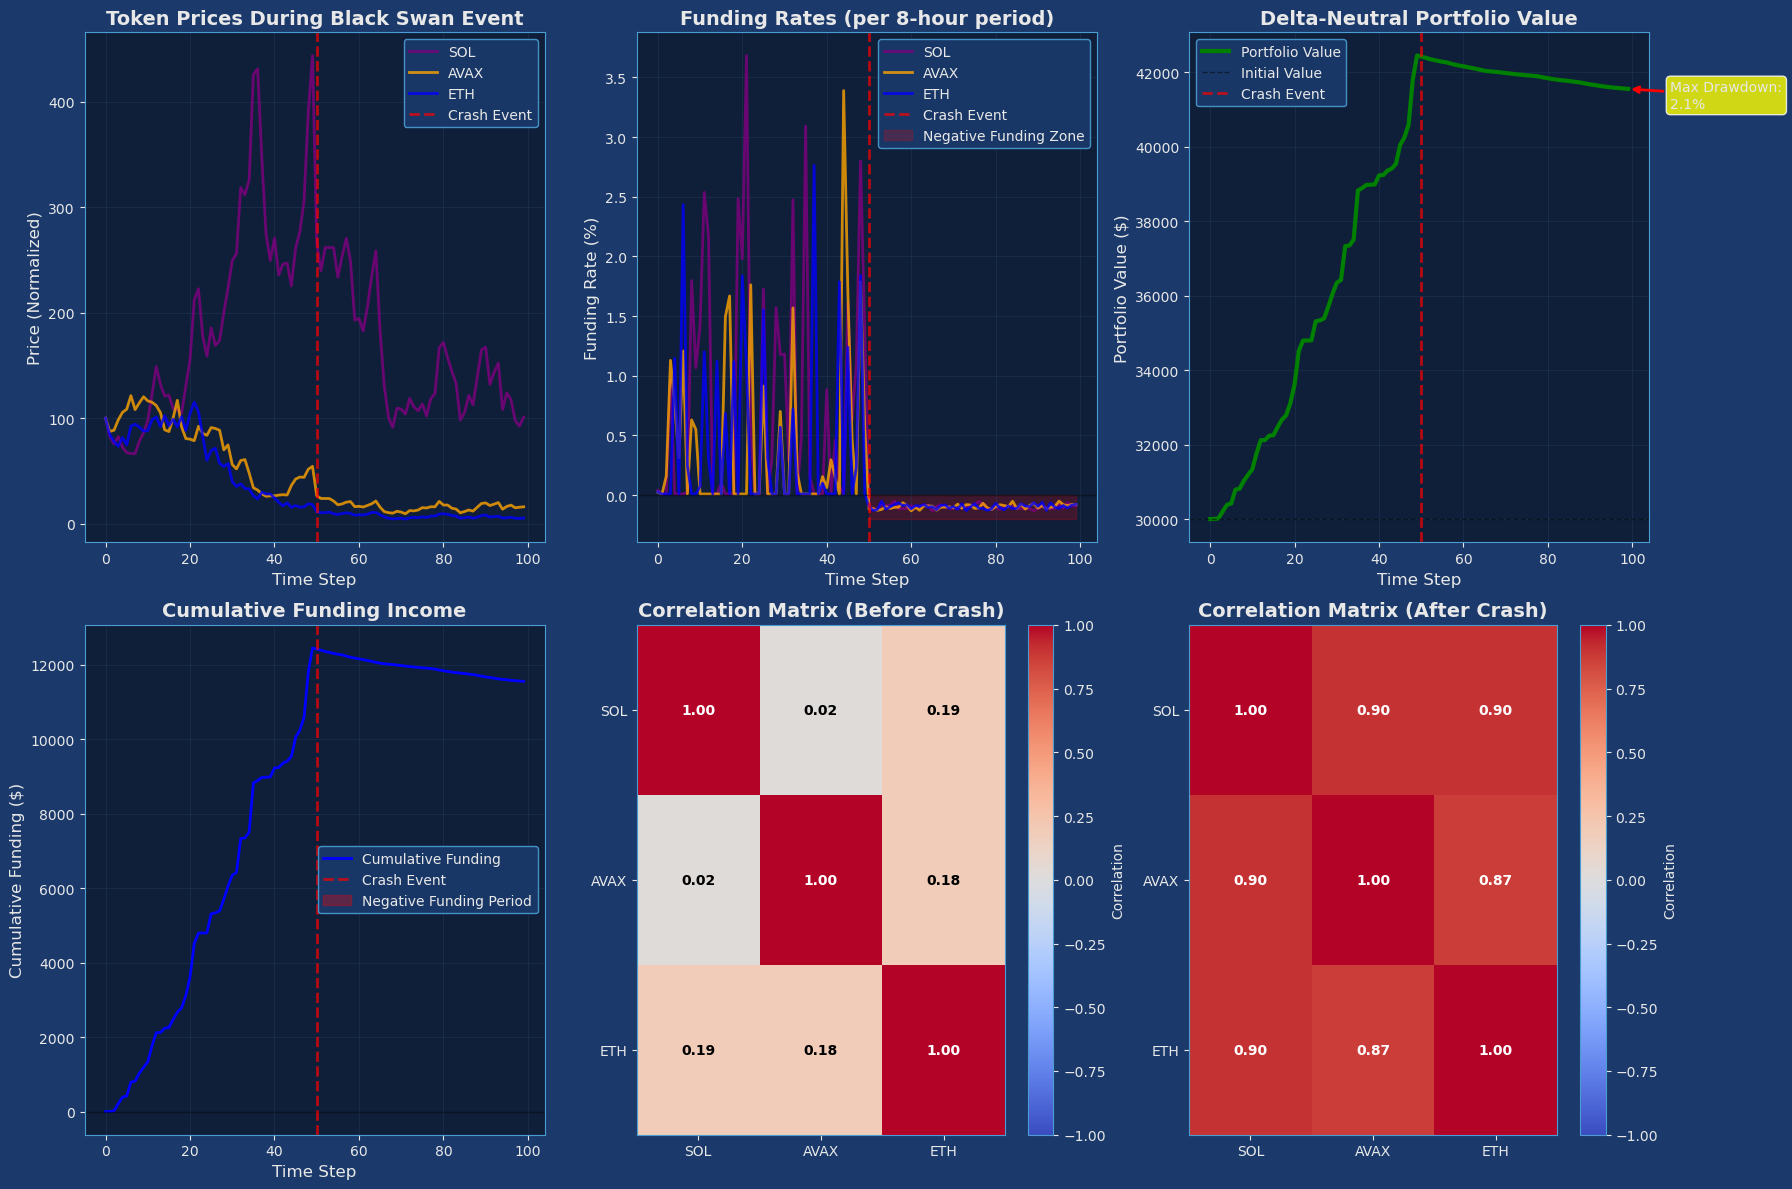


CORRELATION ANALYSIS

Before Crash (Normal Times):
  Average Correlation: 0.128
  Correlation Range: 0.016 to 0.187

After Crash (Black Swan):
  Average Correlation: 0.892
  Correlation Range: 0.874 to 0.904

Correlation Increase: 0.764


In [19]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# Plot 1: Token Prices Over Time
ax1 = plt.subplot(2, 3, 1)
token_names = ['SOL', 'AVAX', 'ETH']
colors = ['purple', 'orange', 'blue']

for i in range(results['num_tokens']):
    ax1.plot(results['prices'][:, i], linewidth=2, color=colors[i], 
            label=token_names[i], alpha=0.8)

ax1.axvline(results['crash_step'], color='red', linestyle='--', linewidth=2, 
           label='Crash Event', alpha=0.7)
ax1.set_title('Token Prices During Black Swan Event', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Price (Normalized)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Funding Rates Over Time
ax2 = plt.subplot(2, 3, 2)
for i in range(results['num_tokens']):
    ax2.plot(results['funding_rates'][:, i] * 100, linewidth=2, color=colors[i], 
            label=token_names[i], alpha=0.8)

ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.axvline(results['crash_step'], color='red', linestyle='--', linewidth=2, 
           label='Crash Event', alpha=0.7)
ax2.fill_between(range(len(results['funding_rates'])), 0, -0.2, 
                where=(np.arange(len(results['funding_rates'])) >= results['crash_step']),
                alpha=0.2, color='red', label='Negative Funding Zone')
ax2.set_title('Funding Rates (per 8-hour period)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Funding Rate (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Portfolio Value
ax3 = plt.subplot(2, 3, 3)
ax3.plot(results['portfolio_value'], linewidth=3, color='green', label='Portfolio Value')
ax3.axhline(results['portfolio_value'][0], color='black', linestyle='--', 
           linewidth=1, alpha=0.5, label='Initial Value')
ax3.axvline(results['crash_step'], color='red', linestyle='--', linewidth=2, 
           label='Crash Event', alpha=0.7)
ax3.set_title('Delta-Neutral Portfolio Value', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time Step', fontsize=12)
ax3.set_ylabel('Portfolio Value ($)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add annotation showing the decline
max_idx = np.argmax(results['portfolio_value'])
min_idx_after_crash = results['crash_step'] + np.argmin(results['portfolio_value'][results['crash_step']:])
max_val = results['portfolio_value'][max_idx]
min_val = results['portfolio_value'][min_idx_after_crash]
ax3.annotate(f'Max Drawdown:\n{((max_val-min_val)/max_val)*100:.1f}%',
            xy=(min_idx_after_crash, min_val),
            xytext=(min_idx_after_crash + 10, min_val - 500),
            fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
# Plot 4: Cumulative Funding Income
ax4 = plt.subplot(2, 3, 4)
ax4.plot(results['cumulative_funding'], linewidth=2, color='blue', label='Cumulative Funding')
ax4.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax4.axvline(results['crash_step'], color='red', linestyle='--', linewidth=2, 
           label='Crash Event', alpha=0.7)
ax4.fill_between(range(len(results['cumulative_funding'])), 0, results['cumulative_funding'],
                where=(results['cumulative_funding'] < 0), alpha=0.3, color='red',
                label='Negative Funding Period')
ax4.set_title('Cumulative Funding Income', fontsize=14, fontweight='bold')
ax4.set_xlabel('Time Step', fontsize=12)
ax4.set_ylabel('Cumulative Funding ($)', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Correlation Matrix - Before Crash
ax5 = plt.subplot(2, 3, 5)
# Calculate correlation from returns before crash
returns_before = results['returns'][:results['crash_step']]
corr_before = np.corrcoef(returns_before.T)
im1 = ax5.imshow(corr_before, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax5.set_xticks(range(results['num_tokens']))
ax5.set_yticks(range(results['num_tokens']))
ax5.set_xticklabels(token_names)
ax5.set_yticklabels(token_names)
ax5.set_title('Correlation Matrix (Before Crash)', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=ax5, label='Correlation')
# Add correlation values
for i in range(results['num_tokens']):
    for j in range(results['num_tokens']):
        ax5.text(j, i, f'{corr_before[i, j]:.2f}', ha='center', va='center',
                color='white' if abs(corr_before[i, j]) > 0.5 else 'black', fontweight='bold')

# Plot 6: Correlation Matrix - After Crash
ax6 = plt.subplot(2, 3, 6)
returns_after = results['returns'][results['crash_step']:]
corr_after = np.corrcoef(returns_after.T)
im2 = ax6.imshow(corr_after, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax6.set_xticks(range(results['num_tokens']))
ax6.set_yticks(range(results['num_tokens']))
ax6.set_xticklabels(token_names)
ax6.set_yticklabels(token_names)
ax6.set_title('Correlation Matrix (After Crash)', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=ax6, label='Correlation')
# Add correlation values
for i in range(results['num_tokens']):
    for j in range(results['num_tokens']):
        ax6.text(j, i, f'{corr_after[i, j]:.2f}', ha='center', va='center',
                color='white' if abs(corr_after[i, j]) > 0.5 else 'black', fontweight='bold')

plt.tight_layout()
plt.show()

# Print correlation analysis
print("\n" + "=" * 70)
print("CORRELATION ANALYSIS")
print("=" * 70)
print("\nBefore Crash (Normal Times):")
print(f"  Average Correlation: {np.mean(corr_before[np.triu_indices_from(corr_before, k=1)]):.3f}")
print(f"  Correlation Range: {np.min(corr_before[np.triu_indices_from(corr_before, k=1)]):.3f} to {np.max(corr_before[np.triu_indices_from(corr_before, k=1)]):.3f}")
print("\nAfter Crash (Black Swan):")
print(f"  Average Correlation: {np.mean(corr_after[np.triu_indices_from(corr_after, k=1)]):.3f}")
print(f"  Correlation Range: {np.min(corr_after[np.triu_indices_from(corr_after, k=1)]):.3f} to {np.max(corr_after[np.triu_indices_from(corr_after, k=1)]):.3f}")
print(f"\nCorrelation Increase: {np.mean(corr_after[np.triu_indices_from(corr_after, k=1)]) - np.mean(corr_before[np.triu_indices_from(corr_before, k=1)]):.3f}")
print("=" * 70)


### 9.3 Why "Delta Neutral" Does Not Mean "Risk Free"

**The Critical Insight:**

Even though the portfolio is **delta-neutral** (price movements cancel out), it still loses value during the Black Swan event. Here's why:

**Mathematical Explanation:**

The portfolio value at time $t$ can be expressed as:

$$ P(t) = P(0) + \sum_{i=1}^{n} \int_{0}^{t} \text{Position}_i(\tau) \times r_i(\tau) \, d\tau $$

Where:
- $P(0)$ = Initial portfolio value
- $n$ = Number of tokens
- $\text{Position}_i(\tau)$ = Position size for token $i$ at time $\tau$
- $r_i(\tau)$ = Funding rate for token $i$ at time $\tau$

**During Normal Times:**
- $r_i(\tau) > 0$ for most tokens (positive funding)
- The integral accumulates positive value
- Portfolio grows steadily

**During Black Swan:**
- $r_i(\tau) < 0$ for **all tokens simultaneously** (correlation convergence)
- The integral accumulates **negative value**
- Portfolio declines despite being delta-neutral

**The Cash Flow Drag:**

The portfolio loses money not from price movement (delta-neutral protects against that), but from **cash flow drag**:

$$ \text{Cash Flow Drag} = \sum_{i=1}^{n} \text{Position}_i \times |r_i| \times \text{Time} $$

When all funding rates turn negative simultaneously, this drag is multiplied across all positions.


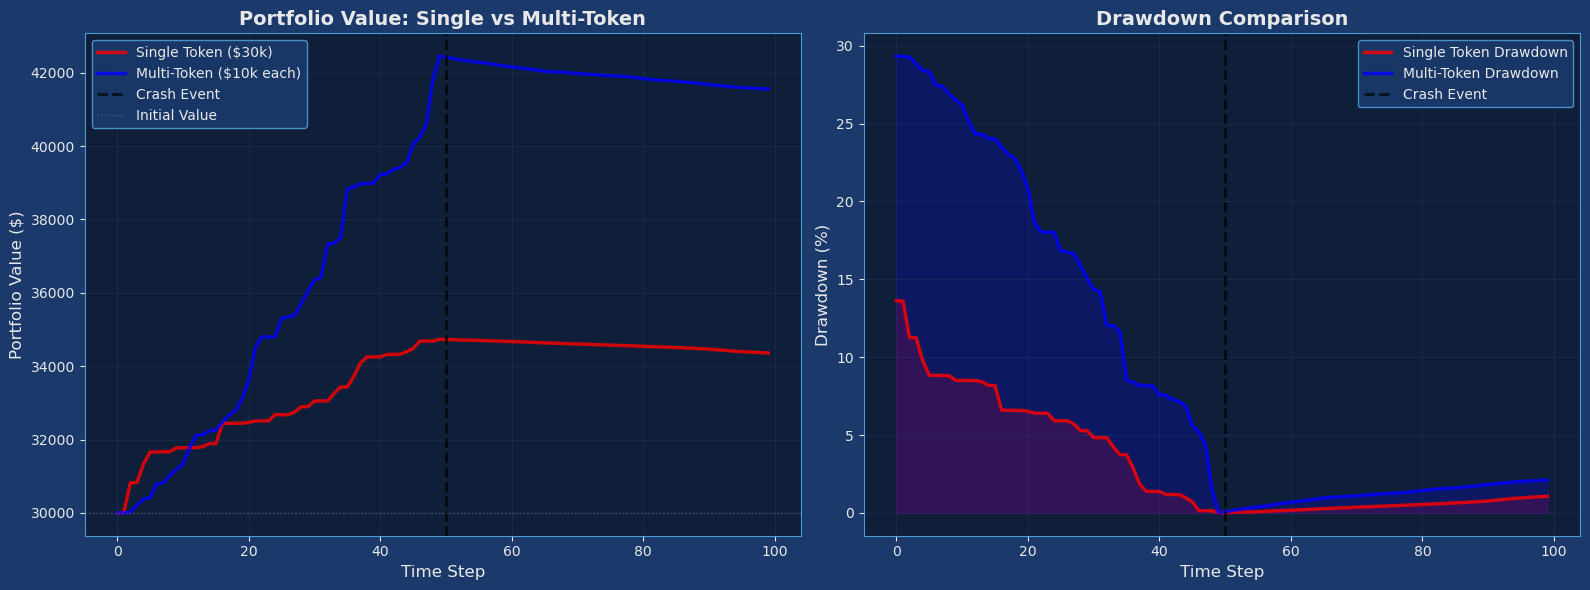


SINGLE TOKEN vs MULTI-TOKEN COMPARISON

Single Token Portfolio:
  Initial: $30,000.00
  Peak: $34,731.13
  Trough: $34,358.28
  Max Drawdown: 13.62%
  Final: $34,358.28

Multi-Token Portfolio:
  Initial: $30,000.00
  Peak: $42,451.98
  Trough: $41,554.53
  Max Drawdown: 29.33%
  Final: $41,554.53

Key Insight:
  During Black Swan events, diversification FAILS because:
  1. Correlations converge to ~1.0 (all assets move together)
  2. Funding rates turn negative simultaneously
  3. Multi-token portfolio suffers from MULTIPLE negative funding streams
  4. 'Delta Neutral' protects against price risk, NOT funding risk


In [20]:
# Compare single token vs multi-token portfolio during crash
def compare_portfolio_strategies():
    """
    Compare:
    1. Single token portfolio
    2. Multi-token portfolio (diversified)
    3. Both during Black Swan event
    """
    # Single token
    single_token = simulate_black_swan_event(
        num_tokens=1, initial_capital=30000, crash_step=50,
        normal_correlation=0.3, crash_correlation=0.9, price_drop=0.4
    )
    
    # Multi-token (3 tokens, $10k each = $30k total)
    multi_token = simulate_black_swan_event(
        num_tokens=3, initial_capital=10000, crash_step=50,
        normal_correlation=0.3, crash_correlation=0.9, price_drop=0.4
    )
    
    return single_token, multi_token

single, multi = compare_portfolio_strategies()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Portfolio Value Comparison
ax1 = axes[0]
ax1.plot(single['portfolio_value'], linewidth=2.5, color='red', 
        label='Single Token ($30k)', alpha=0.8)
ax1.plot(multi['portfolio_value'], linewidth=2.5, color='blue', 
        label='Multi-Token ($10k each)', alpha=0.8)
ax1.axvline(50, color='black', linestyle='--', linewidth=2, 
           label='Crash Event', alpha=0.7)
ax1.axhline(30000, color='gray', linestyle=':', linewidth=1, alpha=0.5, label='Initial Value')
ax1.set_title('Portfolio Value: Single vs Multi-Token', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Drawdown Comparison
ax2 = axes[1]
# Calculate drawdowns
single_peak = np.max(single['portfolio_value'])
single_dd = (single_peak - single['portfolio_value']) / single_peak * 100

multi_peak = np.max(multi['portfolio_value'])
multi_dd = (multi_peak - multi['portfolio_value']) / multi_peak * 100

ax2.plot(single_dd, linewidth=2.5, color='red', 
        label='Single Token Drawdown', alpha=0.8)
ax2.plot(multi_dd, linewidth=2.5, color='blue', 
        label='Multi-Token Drawdown', alpha=0.8)
ax2.axvline(50, color='black', linestyle='--', linewidth=2, 
           label='Crash Event', alpha=0.7)
ax2.fill_between(range(len(single_dd)), single_dd, 0, alpha=0.2, color='red')
ax2.fill_between(range(len(multi_dd)), multi_dd, 0, alpha=0.2, color='blue')
ax2.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("\n" + "=" * 70)
print("SINGLE TOKEN vs MULTI-TOKEN COMPARISON")
print("=" * 70)
print("\nSingle Token Portfolio:")
print(f"  Initial: ${single['portfolio_value'][0]:,.2f}")
print(f"  Peak: ${np.max(single['portfolio_value']):,.2f}")
print(f"  Trough: ${np.min(single['portfolio_value'][50:]):,.2f}")
print(f"  Max Drawdown: {np.max(single_dd):.2f}%")
print(f"  Final: ${single['portfolio_value'][-1]:,.2f}")

print("\nMulti-Token Portfolio:")
print(f"  Initial: ${multi['portfolio_value'][0]:,.2f}")
print(f"  Peak: ${np.max(multi['portfolio_value']):,.2f}")
print(f"  Trough: ${np.min(multi['portfolio_value'][50:]):,.2f}")
print(f"  Max Drawdown: {np.max(multi_dd):.2f}%")
print(f"  Final: ${multi['portfolio_value'][-1]:,.2f}")

print("\nKey Insight:")
print("  During Black Swan events, diversification FAILS because:")
print("  1. Correlations converge to ~1.0 (all assets move together)")
print("  2. Funding rates turn negative simultaneously")
print("  3. Multi-token portfolio suffers from MULTIPLE negative funding streams")
print("  4. 'Delta Neutral' protects against price risk, NOT funding risk")
print("=" * 70)


---
## Part 10: Comparative Analysis - Futures Curve vs Perpetuals

The transcript mentions *"shorting the curve"* (Futures) vs *"buying the cash"* (Spot). This refers to two different arbitrage strategies:

1. **Quarterly Futures Basis Trading**: Trading fixed-maturity futures contracts
2. **Perpetual Funding Rate Arbitrage**: Trading perpetual futures with funding rates

This section compares these two approaches, showing their mathematical differences and practical implications.


### 10.1 Visual Metaphor: Converging Series vs Parallel Line

**Quarterly Futures (Converging Series):**
- Futures price starts above/below spot (basis)
- As expiration approaches, futures price **converges** to spot price
- The convergence is **guaranteed** - it's locked in
- Visual: A curve that approaches a horizontal line (spot price)

**Perpetual Futures (Parallel Line):**
- Perpetual price stays **parallel** to spot price
- Funding rate mechanism keeps them aligned
- The yield is **probabilistic** - funding rates can change
- Visual: Two parallel lines that stay the same distance apart

**Key Difference:**
- **Futures Basis** = Locked-in yield (you know exactly what you'll get)
- **Funding Rate** = Probabilistic yield (depends on market conditions)


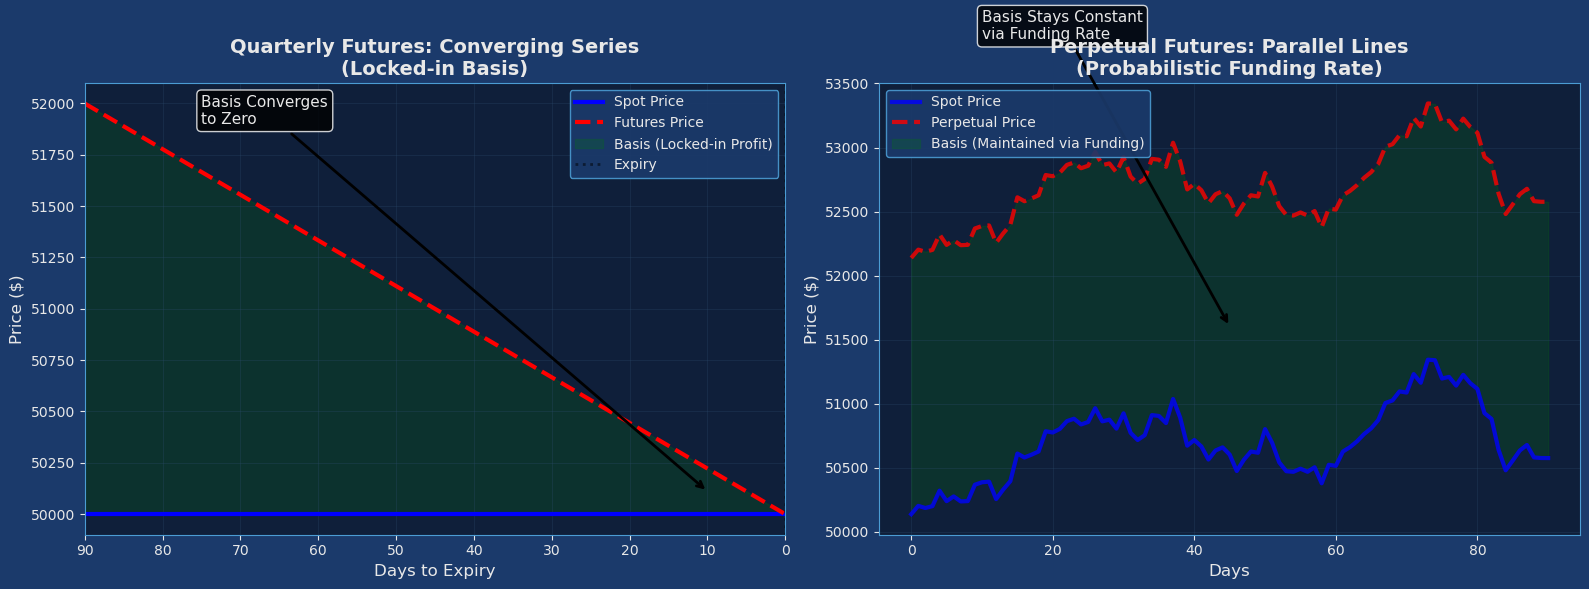

Visual Comparison:
Left Plot (Quarterly Futures):
  • Futures price CONVERGES to spot price
  • Basis (premium) decreases over time
  • Yield is LOCKED-IN at trade initiation

Right Plot (Perpetual Futures):
  • Perpetual price stays PARALLEL to spot price
  • Basis remains constant (maintained by funding rate)
  • Yield is PROBABILISTIC (funding rate can change)


In [21]:
# Visualize the difference between Quarterly Futures and Perpetuals
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Quarterly Futures - Converging Series
ax1 = axes[0]
days_to_expiry = np.linspace(90, 0, 91)
spot_price = 50000
futures_price_initial = 52000  # Futures trading at premium
basis_initial = futures_price_initial - spot_price

# Futures price converges to spot as expiry approaches
# Using exponential convergence model
futures_prices = spot_price + basis_initial * (days_to_expiry / 90)

ax1.plot(days_to_expiry, [spot_price] * len(days_to_expiry), 
        linewidth=3, color='blue', label='Spot Price', linestyle='-')
ax1.plot(days_to_expiry, futures_prices, 
        linewidth=3, color='red', label='Futures Price', linestyle='--')
ax1.fill_between(days_to_expiry, spot_price, futures_prices, 
                alpha=0.2, color='green', label='Basis (Locked-in Profit)')
ax1.axvline(0, color='black', linestyle=':', linewidth=2, alpha=0.5, label='Expiry')
ax1.set_title('Quarterly Futures: Converging Series\n(Locked-in Basis)', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Days to Expiry', fontsize=12)
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()  # Show time counting down to expiry
ax1.set_xlim(90, 0)

# Add annotation
ax1.annotate('Basis Converges\nto Zero',
            xy=(10, spot_price + basis_initial * (10/90) / 2),  # Middle of basis area
            xytext=(75, 51900),  # Text box at top left, within chart bounds
            fontsize=11, bbox=dict(boxstyle='round', facecolor='black', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))
# Plot 2: Perpetual Futures - Parallel Line
ax2 = axes[1]
days = np.linspace(0, 90, 91)
spot_prices = 50000 + np.cumsum(np.random.normal(0, 100, 91))  # Random walk
perpetual_prices = spot_prices + 2000  # Stays parallel (constant basis)

ax2.plot(days, spot_prices, linewidth=3, color='blue', label='Spot Price', alpha=0.8)
ax2.plot(days, perpetual_prices, linewidth=3, color='red', label='Perpetual Price', 
        linestyle='--', alpha=0.8)
ax2.fill_between(days, spot_prices, perpetual_prices, 
                alpha=0.2, color='green', label='Basis (Maintained via Funding)')
ax2.set_title('Perpetual Futures: Parallel Lines\n(Probabilistic Funding Rate)', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Days', fontsize=12)
ax2.set_ylabel('Price ($)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Add annotation
ax2.annotate('Basis Stays Constant\nvia Funding Rate',
            xy=(45, (spot_prices[45] + perpetual_prices[45]) / 2),  # Middle of basis
            xytext=(10, np.max(perpetual_prices) + 500),  # Text box above chart
            fontsize=11, bbox=dict(boxstyle='round', facecolor='black', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='black', lw=2))

plt.tight_layout()
plt.show()

print("Visual Comparison:")
print("=" * 70)
print("Left Plot (Quarterly Futures):")
print("  • Futures price CONVERGES to spot price")
print("  • Basis (premium) decreases over time")
print("  • Yield is LOCKED-IN at trade initiation")
print()
print("Right Plot (Perpetual Futures):")
print("  • Perpetual price stays PARALLEL to spot price")
print("  • Basis remains constant (maintained by funding rate)")
print("  • Yield is PROBABILISTIC (funding rate can change)")
print("=" * 70)


### 10.2 Mathematical Comparison: Locked-in Yield vs Probabilistic Yield

#### Quarterly Futures: Locked-in Yield (Basis Trading)

For a futures contract with fixed expiry, the **implied yield** is locked in at trade initiation:

$$ \text{Implied Yield} = \left(\frac{F - S}{S}\right) \times \frac{365}{T} $$

Where:
- $F$ = Futures price
- $S$ = Spot price
- $T$ = Days to expiry

**Key Characteristics:**
- **Deterministic**: The yield is known and fixed
- **Convergence**: Futures price must equal spot at expiry (arbitrage ensures this)
- **No ongoing payments**: You don't pay/receive funding during the contract life
- **Expiry risk**: Contract expires and must be rolled to next quarter

#### Perpetual Futures: Probabilistic Yield (Funding Rate)

For perpetual futures, the yield comes from funding payments:

$$ \text{Expected Yield} = r_{funding} \times 365 \times \text{Probability}(r > 0) $$

Where $r_{funding}$ is the funding rate (typically paid every 8 hours).

**Key Characteristics:**
- **Probabilistic**: Funding rate changes based on market conditions
- **No expiry**: Contract never expires (perpetual)
- **Ongoing payments**: Funding paid/received every 8 hours
- **Market dependent**: Yield depends on supply/demand dynamics


In [22]:
def calculate_futures_implied_yield(futures_price, spot_price, days_to_expiry, risk_free_rate=0.04):
    """
    Calculate the implied annualized yield from a futures basis trade.
    
    Parameters:
    futures_price: Current futures price
    spot_price: Current spot price
    days_to_expiry: Days until futures contract expires
    risk_free_rate: Risk-free interest rate (default 4%)
    
    Returns:
    implied_yield: Annualized implied yield
    basis: Basis (futures - spot)
    basis_pct: Basis as percentage of spot
    """
    # Calculate basis
    basis = futures_price - spot_price
    basis_pct = (basis / spot_price) * 100
    
    # Calculate implied yield
    # Simple formula: (F - S) / S * 365 / T
    if days_to_expiry > 0:
        implied_yield = (basis / spot_price) * (365 / days_to_expiry)
    else:
        implied_yield = 0  # At expiry, basis should be zero
    
    return implied_yield, basis, basis_pct

# Example from prompt: Futures at $52,000, Spot at $50,000, 90 days to expiry
futures_price_example = 52000
spot_price_example = 50000
days_example = 90

implied_yield, basis, basis_pct = calculate_futures_implied_yield(
    futures_price_example, spot_price_example, days_example
)

print("Futures Basis Trade Example:")
print("=" * 70)
print(f"Spot Price: ${spot_price_example:,.2f}")
print(f"Futures Price: ${futures_price_example:,.2f}")
print(f"Days to Expiry: {days_example}")
print(f"Basis: ${basis:,.2f} ({basis_pct:.2f}%)")
print(f"Implied Annualized Yield: {implied_yield:.2%}")
print()
print("Interpretation:")
print(f"  If you short futures at ${futures_price_example:,.2f} and buy spot at ${spot_price_example:,.2f},")
print(f"  you lock in a {implied_yield:.2%} annualized return.")
print(f"  This yield is GUARANTEED (assuming no default risk).")
print("=" * 70)

# Compare with perpetual funding rate
print("\nComparison with Perpetual Funding Rate:")
print("=" * 70)
print("Quarterly Futures Basis Trade:")
print(f"  Locked-in Yield: {implied_yield:.2%} annualized")
print(f"  Certainty: 100% (guaranteed at expiry)")
print(f"  Duration: {days_example} days (fixed)")
print(f"  Risk: Expiry/roll risk, counterparty risk")
print()
print("Perpetual Funding Rate Arbitrage:")
print(f"  Typical Yield: 50-100% annualized (variable)")
print(f"  Certainty: Probabilistic (depends on market)")
print(f"  Duration: Unlimited (no expiry)")
print(f"  Risk: Funding rate can turn negative, operational risk")
print("=" * 70)


Futures Basis Trade Example:
Spot Price: $50,000.00
Futures Price: $52,000.00
Days to Expiry: 90
Basis: $2,000.00 (4.00%)
Implied Annualized Yield: 16.22%

Interpretation:
  If you short futures at $52,000.00 and buy spot at $50,000.00,
  you lock in a 16.22% annualized return.
  This yield is GUARANTEED (assuming no default risk).

Comparison with Perpetual Funding Rate:
Quarterly Futures Basis Trade:
  Locked-in Yield: 16.22% annualized
  Certainty: 100% (guaranteed at expiry)
  Duration: 90 days (fixed)
  Risk: Expiry/roll risk, counterparty risk

Perpetual Funding Rate Arbitrage:
  Typical Yield: 50-100% annualized (variable)
  Certainty: Probabilistic (depends on market)
  Duration: Unlimited (no expiry)
  Risk: Funding rate can turn negative, operational risk


### 10.3 Detailed Comparison Table

Let's create a comprehensive comparison showing the trade-offs between the two strategies.


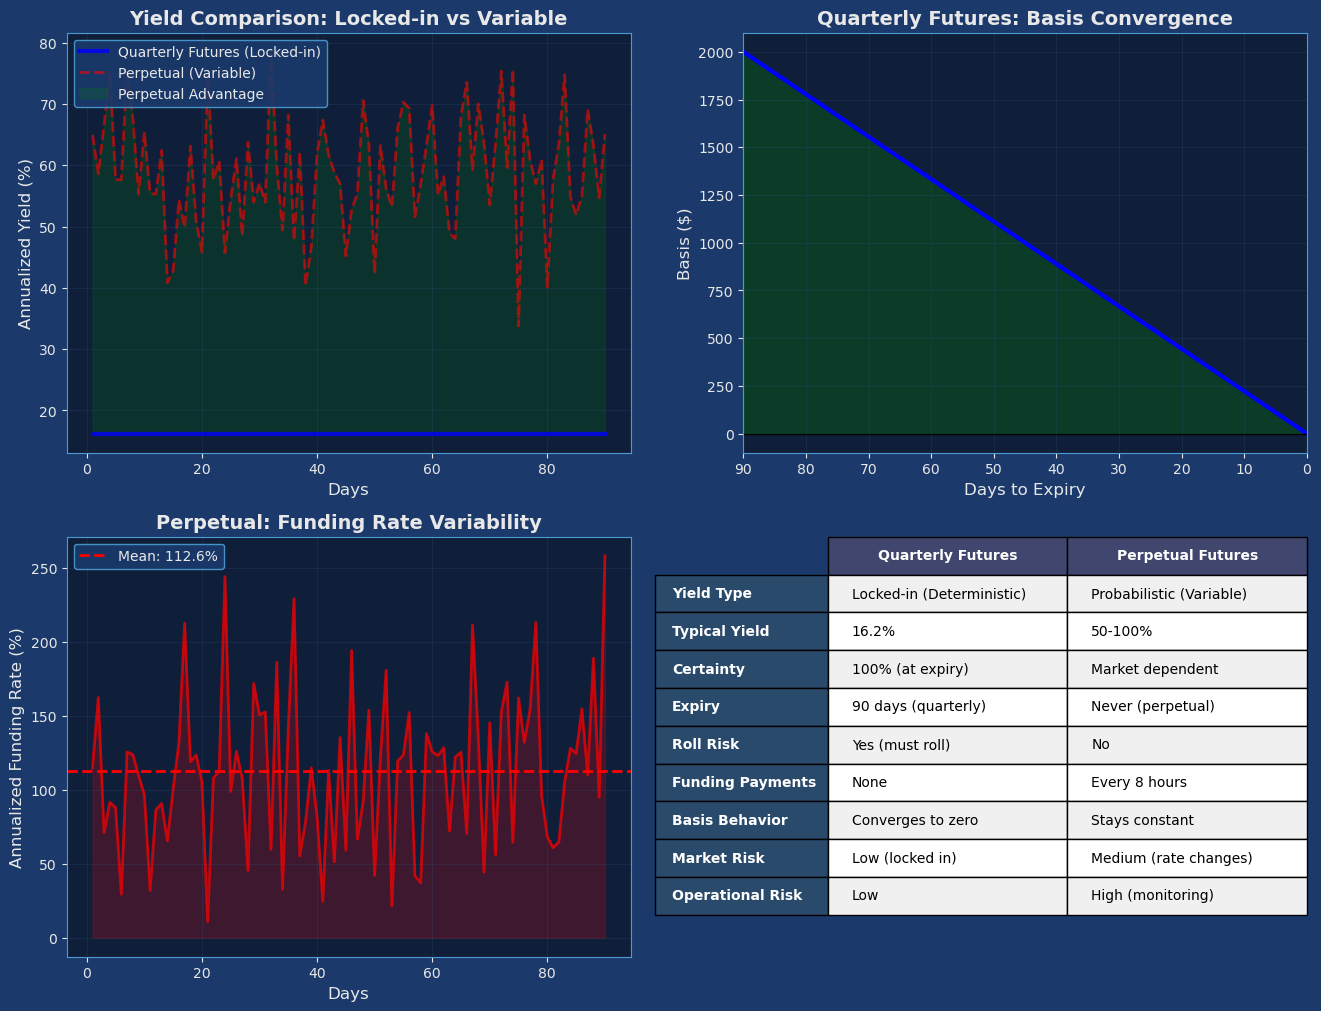

In [23]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Yield Comparison Over Time
ax1 = axes[0, 0]
days_range = np.arange(1, 91)

# Quarterly futures: Yield is constant (locked in)
futures_yield = [implied_yield] * len(days_range)

# Perpetual: Yield varies (simulate with some volatility)
np.random.seed(42)
perpetual_yield_base = 0.60  # 60% annualized
perpetual_yield = perpetual_yield_base + np.random.normal(0, 0.10, len(days_range))
perpetual_yield = np.maximum(perpetual_yield, 0.20)  # Floor at 20%

ax1.plot(days_range, [y * 100 for y in futures_yield], 
        linewidth=3, color='blue', label='Quarterly Futures (Locked-in)', alpha=0.8)
ax1.plot(days_range, [y * 100 for y in perpetual_yield], 
        linewidth=2, color='red', label='Perpetual (Variable)', alpha=0.6, linestyle='--')
ax1.fill_between(days_range, [y * 100 for y in futures_yield], 
                [y * 100 for y in perpetual_yield], 
                where=np.array(perpetual_yield) > np.array(futures_yield),
                alpha=0.2, color='green', label='Perpetual Advantage')
ax1.set_title('Yield Comparison: Locked-in vs Variable', fontsize=14, fontweight='bold')
ax1.set_xlabel('Days', fontsize=12)
ax1.set_ylabel('Annualized Yield (%)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Basis Convergence (Quarterly Futures)
ax2 = axes[0, 1]
days_to_expiry = np.linspace(90, 0, 91)
basis_convergence = basis_initial * (days_to_expiry / 90)

ax2.plot(days_to_expiry, basis_convergence, linewidth=3, color='blue')
ax2.fill_between(days_to_expiry, 0, basis_convergence, alpha=0.3, color='green')
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Quarterly Futures: Basis Convergence', fontsize=14, fontweight='bold')
ax2.set_xlabel('Days to Expiry', fontsize=12)
ax2.set_ylabel('Basis ($)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()
ax2.set_xlim(90, 0)

# Plot 3: Funding Rate Over Time (Perpetual)
ax3 = axes[1, 0]
funding_rates = np.random.normal(0.001, 0.0005, len(days_range))
funding_rates = np.maximum(funding_rates, 0.0001)  # Keep positive
annualized_funding = funding_rates * 3 * 365 * 100  # Convert to annualized %

ax3.plot(days_range, annualized_funding, linewidth=2, color='red', alpha=0.7)
ax3.axhline(np.mean(annualized_funding), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {np.mean(annualized_funding):.1f}%')
ax3.fill_between(days_range, 0, annualized_funding, alpha=0.2, color='red')
ax3.set_title('Perpetual: Funding Rate Variability', fontsize=14, fontweight='bold')
ax3.set_xlabel('Days', fontsize=12)
ax3.set_ylabel('Annualized Funding Rate (%)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Risk-Return Comparison
ax4 = axes[1, 1]
ax4.axis('off')


# Create comparison table
# Create comparison table
comparison_data = [
    ['Aspect', 'Quarterly Futures', 'Perpetual Futures'],
    ['Yield Type', 'Locked-in (Deterministic)', 'Probabilistic (Variable)'],
    ['Typical Yield', f'{implied_yield*100:.1f}%', '50-100%'],
    ['Certainty', '100% (at expiry)', 'Market dependent'],
    ['Expiry', '90 days (quarterly)', 'Never (perpetual)'],
    ['Roll Risk', 'Yes (must roll)', 'No'],
    ['Funding Payments', 'None', 'Every 8 hours'],
    ['Basis Behavior', 'Converges to zero', 'Stays constant'],
    ['Market Risk', 'Low (locked in)', 'Medium (rate changes)'],
    ['Operational Risk', 'Low', 'High (monitoring)'],
]

# Extract data for table
table_data = [row[1:] for row in comparison_data[1:]]  # Data cells (skip header, skip first col)
row_labels = [row[0] for row in comparison_data[1:]]  # Row labels
col_labels = comparison_data[0][1:]  # Column headers (skip 'Aspect')

# Create table
table = ax4.table(
    cellText=table_data,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellLoc='left',
    loc='center',
    bbox=[0.15, 0.1, 0.85, 0.9])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header row (column headers) - white text on dark blue
for j in range(len(col_labels)):
    table[(0, j)].set_facecolor('#40466e')
    table[(0, j)].set_text_props(weight='bold', color='white')

# Style row labels (first column, index -1) - white text on dark blue
for i in range(len(row_labels)):
    table[(i+1, -1)].set_facecolor('#2A4A6B')
    table[(i+1, -1)].set_text_props(weight='bold', color='white')

# Style data cells - dark text on light backgrounds
for i in range(len(table_data)):
    for j in range(len(col_labels)):
        # Set background color first
        if i % 2 == 0:
            table[(i+1, j)].set_facecolor('#f0f0f0')
        else:
            table[(i+1, j)].set_facecolor('white')
        # Then set text color - MUST be dark/black for visibility
        table[(i+1, j)].set_text_props(color='black', weight='normal')



### 10.4 Mathematical Derivation: Futures Basis Formula

The implied yield formula can be derived from the **Cost of Carry Model**:

**Cost of Carry Model:**
$$ F = S \times e^{(r - q) \times T} $$

Where:
- $F$ = Futures price
- $S$ = Spot price
- $r$ = Risk-free rate
- $q$ = Convenience yield (or dividend yield)
- $T$ = Time to expiry (in years)

**For Crypto (no dividends, low risk-free rate):**
$$ F \approx S \times (1 + r \times T) $$

**Solving for Implied Yield:**
$$ \frac{F - S}{S} = r \times T $$

$$ \text{Implied Yield} = \frac{F - S}{S} \times \frac{1}{T} $$

Converting to annualized:
$$ \text{Annualized Yield} = \frac{F - S}{S} \times \frac{365}{T_{days}} $$

**Example Calculation:**
Given: $F = \$52,000$, $S = \$50,000$, $T = 90$ days

$$ \text{Basis} = \$52,000 - \$50,000 = \$2,000 $$

$$ \text{Annualized Yield} = \frac{\$2,000}{\$50,000} \times \frac{365}{90} = 0.04 \times 4.056 = 16.22\% $$

This is the **locked-in yield** you receive by shorting futures and buying spot.


### 10.5 Key Insights: When to Use Each Strategy

**Quarterly Futures Basis Trading:**
- **Best for**: Investors who want certainty and lower operational complexity
- **Yield**: Lower but guaranteed (typically 10-20% annualized)
- **Risk**: Expiry/roll risk, but yield is locked in
- **Example**: Institutional investors, those who can't monitor positions daily

**Perpetual Funding Rate Arbitrage:**
- **Best for**: Active traders who can monitor positions and handle operational complexity
- **Yield**: Higher but variable (typically 50-100%+ annualized)
- **Risk**: Funding rate risk, operational risk, but no expiry risk
- **Example**: Crypto-native traders, those mentioned in the transcript who "understand how to do these things"

**The Transcript's Perspective:**
The transcript emphasizes perpetual funding rate arbitrage because:
1. Higher potential returns (50-100%+ vs 10-20%)
2. No expiry/roll risk
3. More opportunities (hundreds of tokens have perpetuals)
4. Requires expertise → Less competition → Higher returns

**However**, quarterly futures basis trading is:
- More accessible (easier to understand)
- Lower risk (locked-in yield)
- Better for traditional finance backgrounds
- What makes Bitcoin CME "easy" and "not interesting" (narrow spreads)


### 9.4 Key Insights from Black Swan Stress Test

**Critical Findings:**

1. **Correlation Convergence is Real**:
   - Normal times: Correlations ~0.3 (diversification works)
   - Black Swan: Correlations jump to ~0.9 (everything moves together)
   - This is a well-documented phenomenon in financial markets

2. **Delta Neutral ≠ Risk Free**:
   - Delta neutral protects against **price risk**
   - It does NOT protect against **funding rate risk**
   - When funding turns negative, you pay regardless of price movement

3. **The Cash Flow Drag Problem**:
   - During crashes, funding rates turn negative simultaneously
   - With multiple positions, you pay negative funding on ALL positions
   - This creates a **multiplicative cash flow drag**
   - Formula: $\text{Drag} = \sum_{i=1}^{n} \text{Position}_i \times |r_i| \times t$

4. **Diversification Fails During Crashes**:
   - Normal times: Diversification reduces risk
   - Black Swan: All positions suffer simultaneously
   - Multi-token portfolio can actually perform WORSE than single token
   - This is the "correlation risk" mentioned in portfolio theory

5. **Practical Implications**:
   - **Monitor correlations**: If correlations spike, consider reducing positions
   - **Watch funding rates**: If funding turns negative, you're paying, not earning
   - **Have exit strategy**: Know when to close positions if funding stays negative
   - **Capital preservation**: During crashes, preserving capital may be more important than maximizing returns

6. **Connection to Transcript**:
   This validates the transcript's emphasis on:
   - *"Operational risk"* - managing positions during market stress
   - *"Exchange risk"* - different exchanges may handle crashes differently
   - *"Managing margin"* - negative funding can drain margin quickly
   - *"You're getting paid to take risk that other people don't know how to take"* - this includes correlation and funding rate risks


### 8.4 Key Insights from Break-Even Analysis

**Critical Findings:**

1. **Fee Impact is Significant**:
   - Even small fees (0.2% total) can add weeks to break-even time
   - At low funding rates (<30%), high fees can make trades unprofitable
   - This is why exchanges with lower fees are preferred for funding arbitrage

2. **Funding Rate is the Dominant Factor**:
   - Doubling funding rate halves break-even time
   - High funding rates (50-100%+) are essential for quick profitability
   - Low funding rates (<20%) require very low fees to be viable

3. **The "Bucket Analogy" in Practice**:
   - **Fixed Costs** = The size of the hole you need to fill
   - **Funding Rate** = How fast the water (profit) flows in
   - **Break-Even Time** = How long until the bucket is full
   - Higher funding = faster flow = shorter time to fill

4. **Practical Implications**:
   - **Ideal Trade**: >50% funding, <0.2% total fees → Break even in <30 days
   - **Acceptable Trade**: 30-50% funding, <0.3% fees → Break even in 30-90 days
   - **Marginal Trade**: <30% funding or >0.4% fees → Break even in >90 days (risky)

5. **Why This Matters**:
   - Transaction costs are a **real operational risk** mentioned in the transcript
   - High fees can turn a profitable funding rate into an unprofitable trade
   - This is why "understanding how to move collateral quickly between exchanges" matters - different exchanges have different fee structures


### 7.4 Key Insights from the Simulation

**Observations:**

1. **Leverage Amplifies Risk**: 
   - Higher leverage = Lower liquidation price
   - 3x leverage liquidates at a much smaller price increase than 1x leverage
   - The relationship is **non-linear** due to the formula structure

2. **Margin Health Decay**:
   - Margin health decreases linearly as price increases (for short positions)
   - The rate of decay is proportional to leverage
   - Higher leverage = faster decay to liquidation threshold

3. **Liquidation Price Formula**:
   The derived formula $P_{liquidation} = P_{entry} \times \left(1 + \frac{1 - L \times m_{rate}}{L}\right)$ shows:
   - As leverage ($L$) increases, the term $\frac{1 - L \times m_{rate}}{L}$ becomes smaller
   - This means liquidation occurs at a **lower price increase** for higher leverage
   - At very high leverage, liquidation can occur with minimal price movement

4. **Practical Implications**:
   - **1x Leverage**: Safest, can withstand large price moves
   - **2x Leverage**: Moderate risk, still has buffer in most scenarios
   - **3x Leverage**: High risk, liquidates quickly in adverse moves
   - This is why the transcript emphasizes: *"managing margin"* as a key operational risk

5. **The "God Candle" Risk**:
   - Sudden price spikes can liquidate highly leveraged positions instantly
   - Even with delta-neutral strategies, if you're using leverage on the short side, you're exposed to liquidation risk
   - This is an **operational risk** that must be managed continuously
